# 071323 - Semi-supervised learning for classification with clustering-assisted labelling.

## Background

Semi-supervised learning is a type of machine learning where only some of the data is labeled and the goal is to use the labeled data to make predictions on the unlabeled data. Clustering-assisted labeling is a technique used in semi-supervised learning where clustering is used to group similar data points together and then assign labels to these groups.

The basic idea behind clustering-assisted labeling is to use clustering to group similar data points together, and then use the labeled data to assign labels to the clusters. Once the clusters have been labeled, the labels can be propagated to the unlabeled data points in the same cluster.

The advantage of using clustering-assisted labeling is that it allows us to make use of the structure in the data to generate labels for the unlabeled data. This can be particularly useful in cases where labeling the data manually is time-consuming or expensive.

In the context of algo trading, clustering-assisted labeling can be used to create labels for financial data, such as stock prices or exchange rates. The clustering algorithm can be used to group similar data points together based on their attributes, such as volatility or volume. The labeled data can then be used to train a machine learning algorithm to make predictions on the unlabeled data.

To-Do:
- [x] Redo the clustering parameters to stop in January 2023. 
- [x] Tweak Aglo w/o overfitting
- [ ] Calculate Sortino and Sharpe Ratio 

Next Project: 
- [ ] Use DCA method for selling 30% of capital everytime we earned +50%
- [ ] Use FNG or CBBI has a way to invest: while FNG<90%, all-in crypto using DCMA. Is FNG above 90% convert all to USD (or stock)

---
## 0. Imports

In [122]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.preprocessing import StandardScaler

import sys
sys.path.append('../../functions_library')

from functions import ROC, model_selection, Backtesting

#import sklearn 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
import sklearn.ensemble

# Classification Metrics 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc #plot_roc_curve, auc
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

# ML models 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import xgboost as xgb

# libraries for Shapely analysis
import shap 

# Visualization libraries
import matplotlib.pyplot as plt
import hvplot.pandas



seed = 42

---
## 1. Data Loading

--- 
Get latest FNG data 


In [123]:
import requests

url = "https://api.alternative.me/fng/?limit=0&format=json"
response = requests.get(url)

if response.status_code == 200:
    with open("fear_and_greed_index.json", "wb") as file:
        file.write(response.content)
    print("Fear & Greed JSON data downloaded successfully.")
else:
    print("Failed to download FNG data.")

Fear & Greed JSON data downloaded successfully.


In [124]:
fng_json = Path("fear_and_greed_index.json")

import pandas as pd
import json

# Read the JSON data from the file
with open('fear_and_greed_index.json') as file:
    data = json.load(file)

# Extract the "data" section from the JSON
data = data['data']

# Convert the data to a DataFrame
fng_df = pd.DataFrame(data)

In [125]:
# Convert the "timestamp" column to datetime format
fng_df['timestamp'] = pd.to_datetime(fng_df['timestamp'], unit='s')

# Set the "timestamp" column as the index
fng_df.set_index('timestamp', inplace=True)

The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.


In [126]:
fng_df.drop("time_until_update",axis=1,inplace=True)

In [127]:
fng_df.tail()

value value_classification
timestamp                            
2018-02-05    11         Extreme Fear
2018-02-04    24         Extreme Fear
2018-02-03    40                 Fear
2018-02-02    15         Extreme Fear
2018-02-01    30                 Fear

Read the CSV file into Pandas DataFrame

In [128]:
# Import the OHLCV dataset into a Pandas Dataframe
trading_df = pd.read_csv(
    Path("Resources/ETHUSDT-1h-data.csv"), 
    index_col="timestamp", 
    infer_datetime_format=True, 
    parse_dates=True
)

trading_df = trading_df.drop(["close_time","quote_av","trades","tb_base_av","tb_quote_av","ignore"], axis =1)

# Review the DataFrame
trading_df.head()

The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.


open    high    low   close     volume
timestamp                                                    
2017-08-17 04:00:00  301.13  302.57  298.0  301.61  125.66877
2017-08-17 05:00:00  301.61  303.28  300.0  303.10  377.67246
2017-08-17 06:00:00  302.40  304.44  301.9  302.68  303.86672
2017-08-17 07:00:00  302.68  307.96  302.6  307.96  754.74510
2017-08-17 08:00:00  307.95  309.97  307.0  308.62  150.75029

In [129]:
# drop duplicate index label
trading_df = trading_df[~trading_df.index.duplicated(keep='first')]

In [130]:
trading_df.tail()

open     high      low    close      volume
timestamp                                                          
2023-07-24 10:00:00  1842.42  1853.32  1839.29  1852.47  30401.4868
2023-07-24 11:00:00  1852.46  1855.31  1850.84  1853.04  12417.4495
2023-07-24 12:00:00  1853.04  1853.18  1847.36  1852.38  11788.9408
2023-07-24 13:00:00  1852.37  1854.76  1846.29  1850.56  12701.3581
2023-07-24 14:00:00  1850.56  1850.98  1844.00  1844.60  10167.4844

Add a daily return values column to the DataFrame

In [131]:
# Calculate the daily returns using the closing prices and the pct_change function
trading_df["daily_returns"] = trading_df["close"].pct_change()

# Drop all NaN values from the DataFrame
trading_df = trading_df.dropna()

# Review the DataFrame
display(trading_df.head())
display(trading_df.tail())

open    high     low   close     volume  daily_returns
timestamp                                                                    
2017-08-17 05:00:00  301.61  303.28  300.00  303.10  377.67246       0.004940
2017-08-17 06:00:00  302.40  304.44  301.90  302.68  303.86672      -0.001386
2017-08-17 07:00:00  302.68  307.96  302.60  307.96  754.74510       0.017444
2017-08-17 08:00:00  307.95  309.97  307.00  308.62  150.75029       0.002143
2017-08-17 09:00:00  308.62  312.00  308.62  310.00  469.27879       0.004472

open     high      low    close      volume  \
timestamp                                                             
2023-07-24 10:00:00  1842.42  1853.32  1839.29  1852.47  30401.4868   
2023-07-24 11:00:00  1852.46  1855.31  1850.84  1853.04  12417.4495   
2023-07-24 12:00:00  1853.04  1853.18  1847.36  1852.38  11788.9408   
2023-07-24 13:00:00  1852.37  1854.76  1846.29  1850.56  12701.3581   
2023-07-24 14:00:00  1850.56  1850.98  1844.00  1844.60  10167.4844   

                     daily_returns  
timestamp                           
2023-07-24 10:00:00       0.005455  
2023-07-24 11:00:00       0.000308  
2023-07-24 12:00:00      -0.000356  
2023-07-24 13:00:00      -0.000983  
2023-07-24 14:00:00      -0.003221

In [132]:
CBBI_json = Path("Resources/CBBI.json")

In [133]:
CBBI_df = pd.read_json(
    CBBI_json,
    #index_col="timestamp", 
    #infer_datetime_format=True, 
    #parse_dates=True,
    #dayfirst=True
    )

CBBI_df = CBBI_df.rename(columns={'Confidence': 'CBBI'})

In [134]:
CBBI_df

Price  PiCycle    RUPL   RHODL   Puell    2YMA  Trolololo  \
2011-06-27     15.5900      NaN  0.8152  0.8691  0.7548  0.6390     0.8024   
2011-06-28     17.0100      NaN  0.8105  0.8681  0.7604  0.6568     0.8289   
2011-06-29     16.9300      NaN  0.8078  0.8641  0.7758  0.6512     0.8256   
2011-06-30     16.8971      NaN  0.7992  0.7854  0.8006  0.6465     0.8233   
2011-07-01     16.5100      NaN  0.7884  0.7802  0.7620  0.6367     0.8140   
...                ...      ...     ...     ...     ...     ...        ...   
2023-06-29  30097.0000   0.5791  0.6292  0.0719  0.5403  0.2114     0.1079   
2023-06-30  30463.0000   0.5809  0.6297  0.0812  0.5782  0.2179     0.1130   
2023-07-01  30510.0000   0.5826  0.6304  0.0847  0.5060  0.2188     0.1133   
2023-07-02  30584.0000   0.5839  0.6308  0.0831  0.6118  0.2201     0.1140   
2023-07-03  31025.3660   0.5847  0.6308  0.0830  0.6119  0.2277     0.1202   

              MVRV  ReserveRisk  Woobull    CBBI  
2011-06-27  0.5246          NaN   0.5948  0.7143  
2011-06-28  0.5190       0.9311   0.6215  0.7495  
2011-06-29  0.5151       0.9318   0.6201  0.7489  
2011-06-30  0.5043       0.9329   0.6195  0.7390  
2011-07-01  0.4896       0.9294   0.5949  0.7244  
...            ...          ...      ...     ...  
2023-06-29  0.3135       0.0000   0.2624  0.3017  
2023-06-30  0.3099       0.0000   0.2671  0.3086  
2023-07-01  0.3084       0.0000   0.2677  0.3013  
2023-07-02  0.3047       0.0000   0.2687  0.3130  
2023-07-03  0.3117       0.0000   0.2742  0.3160  

[4390 rows x 11 columns]

In [135]:
#timestamp,value,value_classification
#resample to 1H timeframe
CBBI_df = CBBI_df.resample('1H').ffill()
fng_df = fng_df.resample('1H').ffill()

In [136]:
fng_df

value value_classification
timestamp                                     
2018-02-01 00:00:00    30                 Fear
2018-02-01 01:00:00    30                 Fear
2018-02-01 02:00:00    30                 Fear
2018-02-01 03:00:00    30                 Fear
2018-02-01 04:00:00    30                 Fear
...                   ...                  ...
2023-07-23 20:00:00    54              Neutral
2023-07-23 21:00:00    54              Neutral
2023-07-23 22:00:00    54              Neutral
2023-07-23 23:00:00    54              Neutral
2023-07-24 00:00:00    55                Greed

[47977 rows x 2 columns]

In [137]:
# Cut off for 'Confidence'
cutoffs = [-0.1, 0.25,0.45,0.55, 0.75,1.1]
labels = ['X-Low','Low','Neutral', 'High', 'X-High']

CBBI_df['CBBI_class'] = pd.cut(CBBI_df['CBBI'], bins=cutoffs, labels=labels)

In [138]:
CBBI_df 

Price  PiCycle    RUPL   RHODL   Puell    2YMA  \
2011-06-27 00:00:00     15.590      NaN  0.8152  0.8691  0.7548  0.6390   
2011-06-27 01:00:00     15.590      NaN  0.8152  0.8691  0.7548  0.6390   
2011-06-27 02:00:00     15.590      NaN  0.8152  0.8691  0.7548  0.6390   
2011-06-27 03:00:00     15.590      NaN  0.8152  0.8691  0.7548  0.6390   
2011-06-27 04:00:00     15.590      NaN  0.8152  0.8691  0.7548  0.6390   
...                        ...      ...     ...     ...     ...     ...   
2023-07-02 20:00:00  30584.000   0.5839  0.6308  0.0831  0.6118  0.2201   
2023-07-02 21:00:00  30584.000   0.5839  0.6308  0.0831  0.6118  0.2201   
2023-07-02 22:00:00  30584.000   0.5839  0.6308  0.0831  0.6118  0.2201   
2023-07-02 23:00:00  30584.000   0.5839  0.6308  0.0831  0.6118  0.2201   
2023-07-03 00:00:00  31025.366   0.5847  0.6308  0.0830  0.6119  0.2277   

                     Trolololo    MVRV  ReserveRisk  Woobull    CBBI  \
2011-06-27 00:00:00     0.8024  0.5246          NaN   0.5948  0.7143   
2011-06-27 01:00:00     0.8024  0.5246          NaN   0.5948  0.7143   
2011-06-27 02:00:00     0.8024  0.5246          NaN   0.5948  0.7143   
2011-06-27 03:00:00     0.8024  0.5246          NaN   0.5948  0.7143   
2011-06-27 04:00:00     0.8024  0.5246          NaN   0.5948  0.7143   
...                        ...     ...          ...      ...     ...   
2023-07-02 20:00:00     0.1140  0.3047          0.0   0.2687  0.3130   
2023-07-02 21:00:00     0.1140  0.3047          0.0   0.2687  0.3130   
2023-07-02 22:00:00     0.1140  0.3047          0.0   0.2687  0.3130   
2023-07-02 23:00:00     0.1140  0.3047          0.0   0.2687  0.3130   
2023-07-03 00:00:00     0.1202  0.3117          0.0   0.2742  0.3160   

                    CBBI_class  
2011-06-27 00:00:00       High  
2011-06-27 01:00:00       High  
2011-06-27 02:00:00       High  
2011-06-27 03:00:00       High  
2011-06-27 04:00:00       High  
...                        ...  
2023-07-02 20:00:00        Low  
2023-07-02 21:00:00        Low  
2023-07-02 22:00:00        Low  
2023-07-02 23:00:00        Low  
2023-07-03 00:00:00        Low  

[105337 rows x 12 columns]

In [139]:
# rename column 'B' to 'C'
fng_df = fng_df.rename(columns={'value':'fng'})
fng_df = fng_df.rename(columns={'value_classification':'fng_class'})


In [140]:
fng_df['fng'] = fng_df['fng'].astype(int)
fng_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 47977 entries, 2018-02-01 00:00:00 to 2023-07-24 00:00:00
Freq: H
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   fng        47977 non-null  int64 
 1   fng_class  47977 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


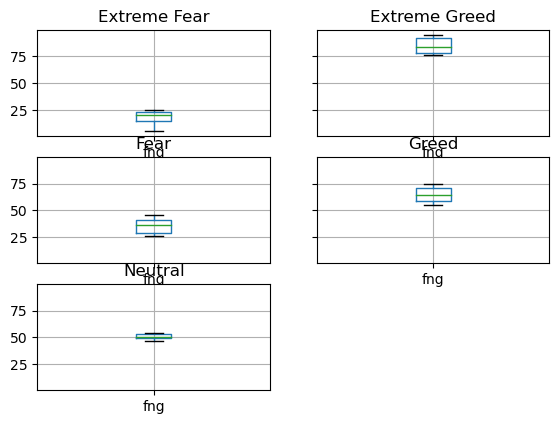

In [141]:
# Group by fng_classification and display boxplots for other columns
fng_df.groupby("fng_class").boxplot(column=["fng"])

# Show the plot
plt.show()

In [142]:
fng_df["fng_class"].value_counts()

fng_class
Fear             15552
Extreme Fear     12744
Greed             9553
Neutral           5688
Extreme Greed     4440
Name: count, dtype: int64

In [143]:
merged_df = pd.merge(fng_df, trading_df, how='inner', left_index=True, right_index=True)


In [144]:
merged_df = pd.merge(merged_df, CBBI_df, how='inner', left_index=True, right_index=True)

In [145]:
merged_df.dropna()

fng fng_class     open     high      low    close  \
2018-02-01 00:00:00   30      Fear  1125.96  1137.99  1120.56  1132.00   
2018-02-01 01:00:00   30      Fear  1132.00  1140.89  1125.01  1135.00   
2018-02-01 02:00:00   30      Fear  1134.07  1154.99  1134.07  1150.50   
2018-02-01 03:00:00   30      Fear  1150.51  1164.99  1125.01  1140.00   
2018-02-01 04:00:00   30      Fear  1140.00  1154.72  1130.18  1152.51   
...                  ...       ...      ...      ...      ...      ...   
2023-07-02 20:00:00   63     Greed  1914.12  1920.39  1911.26  1918.39   
2023-07-02 21:00:00   63     Greed  1918.39  1924.98  1917.83  1921.00   
2023-07-02 22:00:00   63     Greed  1921.01  1959.20  1912.28  1942.05   
2023-07-02 23:00:00   63     Greed  1942.04  1944.09  1930.61  1937.48   
2023-07-03 00:00:00   62     Greed  1937.49  1942.27  1933.55  1934.88   

                          volume  daily_returns      Price  PiCycle    RUPL  \
2018-02-01 00:00:00   3465.84651       0.006392  10035.430   0.9524  0.7264   
2018-02-01 01:00:00   4149.14991       0.002650  10035.430   0.9524  0.7264   
2018-02-01 02:00:00   4828.74525       0.013656  10035.430   0.9524  0.7264   
2018-02-01 03:00:00   7622.31840      -0.009126  10035.430   0.9524  0.7264   
2018-02-01 04:00:00   3899.48396       0.010974  10035.430   0.9524  0.7264   
...                          ...            ...        ...      ...     ...   
2023-07-02 20:00:00   4090.48240       0.002231  30584.000   0.5839  0.6308   
2023-07-02 21:00:00   6308.24160       0.001361  30584.000   0.5839  0.6308   
2023-07-02 22:00:00  65668.79600       0.010958  30584.000   0.5839  0.6308   
2023-07-02 23:00:00  15266.67150      -0.002353  30584.000   0.5839  0.6308   
2023-07-03 00:00:00   8265.95380      -0.001342  31025.366   0.5847  0.6308   

                      RHODL   Puell    2YMA  Trolololo    MVRV  ReserveRisk  \
2018-02-01 00:00:00  0.8461  0.5985  0.6575     0.6960  0.5987        0.798   
2018-02-01 01:00:00  0.8461  0.5985  0.6575     0.6960  0.5987        0.798   
2018-02-01 02:00:00  0.8461  0.5985  0.6575     0.6960  0.5987        0.798   
2018-02-01 03:00:00  0.8461  0.5985  0.6575     0.6960  0.5987        0.798   
2018-02-01 04:00:00  0.8461  0.5985  0.6575     0.6960  0.5987        0.798   
...                     ...     ...     ...        ...     ...          ...   
2023-07-02 20:00:00  0.0831  0.6118  0.2201     0.1140  0.3047        0.000   
2023-07-02 21:00:00  0.0831  0.6118  0.2201     0.1140  0.3047        0.000   
2023-07-02 22:00:00  0.0831  0.6118  0.2201     0.1140  0.3047        0.000   
2023-07-02 23:00:00  0.0831  0.6118  0.2201     0.1140  0.3047        0.000   
2023-07-03 00:00:00  0.0830  0.6119  0.2277     0.1202  0.3117        0.000   

                     Woobull    CBBI CBBI_class  
2018-02-01 00:00:00   0.6076  0.7202       High  
2018-02-01 01:00:00   0.6076  0.7202       High  
2018-02-01 02:00:00   0.6076  0.7202       High  
2018-02-01 03:00:00   0.6076  0.7202       High  
2018-02-01 04:00:00   0.6076  0.7202       High  
...                      ...     ...        ...  
2023-07-02 20:00:00   0.2687  0.3130        Low  
2023-07-02 21:00:00   0.2687  0.3130        Low  
2023-07-02 22:00:00   0.2687  0.3130        Low  
2023-07-02 23:00:00   0.2687  0.3130        Low  
2023-07-03 00:00:00   0.2742  0.3160        Low  

[47352 rows x 20 columns]

In [146]:
merged_df

fng fng_class     open     high      low    close  \
2018-02-01 00:00:00   30      Fear  1125.96  1137.99  1120.56  1132.00   
2018-02-01 01:00:00   30      Fear  1132.00  1140.89  1125.01  1135.00   
2018-02-01 02:00:00   30      Fear  1134.07  1154.99  1134.07  1150.50   
2018-02-01 03:00:00   30      Fear  1150.51  1164.99  1125.01  1140.00   
2018-02-01 04:00:00   30      Fear  1140.00  1154.72  1130.18  1152.51   
...                  ...       ...      ...      ...      ...      ...   
2023-07-02 20:00:00   63     Greed  1914.12  1920.39  1911.26  1918.39   
2023-07-02 21:00:00   63     Greed  1918.39  1924.98  1917.83  1921.00   
2023-07-02 22:00:00   63     Greed  1921.01  1959.20  1912.28  1942.05   
2023-07-02 23:00:00   63     Greed  1942.04  1944.09  1930.61  1937.48   
2023-07-03 00:00:00   62     Greed  1937.49  1942.27  1933.55  1934.88   

                          volume  daily_returns      Price  PiCycle    RUPL  \
2018-02-01 00:00:00   3465.84651       0.006392  10035.430   0.9524  0.7264   
2018-02-01 01:00:00   4149.14991       0.002650  10035.430   0.9524  0.7264   
2018-02-01 02:00:00   4828.74525       0.013656  10035.430   0.9524  0.7264   
2018-02-01 03:00:00   7622.31840      -0.009126  10035.430   0.9524  0.7264   
2018-02-01 04:00:00   3899.48396       0.010974  10035.430   0.9524  0.7264   
...                          ...            ...        ...      ...     ...   
2023-07-02 20:00:00   4090.48240       0.002231  30584.000   0.5839  0.6308   
2023-07-02 21:00:00   6308.24160       0.001361  30584.000   0.5839  0.6308   
2023-07-02 22:00:00  65668.79600       0.010958  30584.000   0.5839  0.6308   
2023-07-02 23:00:00  15266.67150      -0.002353  30584.000   0.5839  0.6308   
2023-07-03 00:00:00   8265.95380      -0.001342  31025.366   0.5847  0.6308   

                      RHODL   Puell    2YMA  Trolololo    MVRV  ReserveRisk  \
2018-02-01 00:00:00  0.8461  0.5985  0.6575     0.6960  0.5987        0.798   
2018-02-01 01:00:00  0.8461  0.5985  0.6575     0.6960  0.5987        0.798   
2018-02-01 02:00:00  0.8461  0.5985  0.6575     0.6960  0.5987        0.798   
2018-02-01 03:00:00  0.8461  0.5985  0.6575     0.6960  0.5987        0.798   
2018-02-01 04:00:00  0.8461  0.5985  0.6575     0.6960  0.5987        0.798   
...                     ...     ...     ...        ...     ...          ...   
2023-07-02 20:00:00  0.0831  0.6118  0.2201     0.1140  0.3047        0.000   
2023-07-02 21:00:00  0.0831  0.6118  0.2201     0.1140  0.3047        0.000   
2023-07-02 22:00:00  0.0831  0.6118  0.2201     0.1140  0.3047        0.000   
2023-07-02 23:00:00  0.0831  0.6118  0.2201     0.1140  0.3047        0.000   
2023-07-03 00:00:00  0.0830  0.6119  0.2277     0.1202  0.3117        0.000   

                     Woobull    CBBI CBBI_class  
2018-02-01 00:00:00   0.6076  0.7202       High  
2018-02-01 01:00:00   0.6076  0.7202       High  
2018-02-01 02:00:00   0.6076  0.7202       High  
2018-02-01 03:00:00   0.6076  0.7202       High  
2018-02-01 04:00:00   0.6076  0.7202       High  
...                      ...     ...        ...  
2023-07-02 20:00:00   0.2687  0.3130        Low  
2023-07-02 21:00:00   0.2687  0.3130        Low  
2023-07-02 22:00:00   0.2687  0.3130        Low  
2023-07-02 23:00:00   0.2687  0.3130        Low  
2023-07-03 00:00:00   0.2742  0.3160        Low  

[47352 rows x 20 columns]

---
## 2. Feature Engineering

# drop duplicate index label
merged_df = merged_df[~merged_df.index.duplicated(keep='first')]

In [147]:
import finta as ft
from finta import TA
import talib

ohlcv_df = merged_df

# List of time periods to use for Moving Averages calculation
timeperiods = [100,200,300,500,750,1000,1500]

df_eng = ohlcv_df.copy()

# Calculate SMAs and add them to the DataFrame
for t in timeperiods:
    #tsma = TA.SMA(df_eng t).shift(1)
    sma = TA.SMA(df_eng,t)
    ema = TA.EMA(df_eng,t)
    atr = TA.ATR(df_eng,t)  #Average True Range
    adx = TA.ADX(df_eng,t) 
    rsi = TA.RSI(df_eng,t)
    hma = TA.HMA(df_eng,t)
    vama = TA.VAMA(df_eng,t)
 
    # calculate the Force Index
    force_index = pd.Series(df_eng['close'].diff(1) * df_eng['volume'], index=df_eng.index)
    force_ema = force_index.ewm(span=t, min_periods=0, adjust=True, ignore_na=False).mean()    
    
    #df['force_index'] = force_index
    #df[f'force_index_ema_{t}'] = force_ema # add the Force Index and its EMA to the DataFrame
    #df[f'TSMA_{t}'] = tsma
    df_eng[f'SMA_{t}'] = sma
    df_eng[f'EMA_{t}'] = ema
    df_eng[f'HMA_{t}'] = hma
    df_eng[f'VAMA_{t}'] = vama
    df_eng[f'ATR_{t}'] = atr
    df_eng[f'ADX_{t}'] = adx
    df_eng[f'RSI_{t}'] = rsi
    
    
# Calculate the Parabolic SAR
#sar = TA.PSAR(df)

# Add the SAR values and trend direction to the DataFrame
#df['sar'] = sar['psar']
#df['psarbear'] = sar['psarbear']
#df['psarbull'] = sar['psarbull']

df_eng['UO'] = TA.UO(df_eng)

# Adding Awesome Indicator (AO)
df_eng['AO'] = TA.AO(df_eng)
df_eng['OBV'] =TA.OBV(df_eng)

# Adding Chaikin Indicator 
df_eng['CHAIKIN'] = TA.CHAIKIN(df_eng)

# Adding Bollinger Bands
df_eng[['BB_UPPER','BB_MED','BB_LOWER']] =TA.BBANDS(df_eng)

# Calculate the Keltner Channel with TALIB
#df[['KC_UPPER','KC_MED','KC_LOWER']] = TA.KC(df)

# calculate Commodity Channel Index (CCI)
df_eng['cci'] = TA.CCI(df_eng)

# assuming you have OHLCV data in a pandas dataframe called "df"
#volume_momentum = talib.MOM(df['volume'])

In [148]:
# check for duplicate index labels
print(df_eng.index.duplicated().any())

False


In [149]:
# drop duplicate index label
df_eng = df_eng[~df_eng.index.duplicated(keep='first')]


In [150]:
df_eng.dropna()

fng fng_class     open     high      low    close  \
2018-06-07 07:00:00   38      Fear   607.60   610.30   606.69   609.58   
2018-06-07 08:00:00   38      Fear   609.18   613.12   608.00   608.18   
2018-06-07 09:00:00   38      Fear   608.62   611.00   606.25   609.64   
2018-06-07 10:00:00   38      Fear   609.64   610.47   606.41   607.99   
2018-06-07 11:00:00   38      Fear   607.62   609.10   607.00   607.60   
...                  ...       ...      ...      ...      ...      ...   
2023-07-02 20:00:00   63     Greed  1914.12  1920.39  1911.26  1918.39   
2023-07-02 21:00:00   63     Greed  1918.39  1924.98  1917.83  1921.00   
2023-07-02 22:00:00   63     Greed  1921.01  1959.20  1912.28  1942.05   
2023-07-02 23:00:00   63     Greed  1942.04  1944.09  1930.61  1937.48   
2023-07-03 00:00:00   62     Greed  1937.49  1942.27  1933.55  1934.88   

                          volume  daily_returns      Price  PiCycle  ...  \
2018-06-07 07:00:00   2097.03849       0.003738   7607.200   0.5114  ...   
2018-06-07 08:00:00   4142.71778      -0.002297   7607.200   0.5114  ...   
2018-06-07 09:00:00   2678.96166       0.002401   7607.200   0.5114  ...   
2018-06-07 10:00:00   1989.56528      -0.002707   7607.200   0.5114  ...   
2018-06-07 11:00:00   1659.15096      -0.000641   7607.200   0.5114  ...   
...                          ...            ...        ...      ...  ...   
2023-07-02 20:00:00   4090.48240       0.002231  30584.000   0.5839  ...   
2023-07-02 21:00:00   6308.24160       0.001361  30584.000   0.5839  ...   
2023-07-02 22:00:00  65668.79600       0.010958  30584.000   0.5839  ...   
2023-07-02 23:00:00  15266.67150      -0.002353  30584.000   0.5839  ...   
2023-07-03 00:00:00   8265.95380      -0.001342  31025.366   0.5847  ...   

                     ADX_1500   RSI_1500         UO         AO           OBV  \
2018-06-07 07:00:00  8.571318  49.298629  50.363159   4.206912 -2.646947e+05   
2018-06-07 08:00:00  8.566531  49.288221  44.614618   3.532824 -2.688375e+05   
2018-06-07 09:00:00  8.561799  49.299391  49.316224   2.693529 -2.661585e+05   
2018-06-07 10:00:00  8.557074  49.287114  44.739307   2.213676 -2.681481e+05   
2018-06-07 11:00:00  8.552356  49.284211  45.688991   2.060029 -2.698072e+05   
...                       ...        ...        ...        ...           ...   
2023-07-02 20:00:00  2.158213  50.827453  65.333367  -4.878471 -2.299461e+06   
2023-07-02 21:00:00  2.157455  50.843217  62.691445  -4.565118 -2.293152e+06   
2023-07-02 22:00:00  2.156359  50.970071  59.785279  -0.114559 -2.227484e+06   
2023-07-02 23:00:00  2.155264  50.941512  60.658379   5.658471 -2.242750e+06   
2023-07-03 00:00:00  2.154170  50.925267  61.102198  10.292324 -2.251016e+06   

                          CHAIKIN     BB_UPPER     BB_MED     BB_LOWER  \
2018-06-07 07:00:00      7.952622   619.432606   607.4410   595.449394   
2018-06-07 08:00:00  -1162.314916   619.200585   607.3085   595.416415   
2018-06-07 09:00:00  -1171.108221   619.299418   607.3705   595.441582   
2018-06-07 10:00:00  -1208.570938   619.310086   607.3795   595.448914   
2018-06-07 11:00:00  -1340.274368   618.981784   607.1940   595.406216   
...                           ...          ...        ...          ...   
2023-07-02 20:00:00   7087.038448  1924.124087  1916.2065  1908.288913   
2023-07-02 21:00:00   6373.891769  1924.236325  1916.2400  1908.243675   
2023-07-02 22:00:00  11122.698108  1931.382938  1917.3640  1903.345062   
2023-07-02 23:00:00  12147.929381  1935.076144  1918.5425  1902.008856   
2023-07-03 00:00:00   9635.202638  1937.480931  1919.6160  1901.751069   

                            cci  
2018-06-07 07:00:00   24.362937  
2018-06-07 08:00:00   37.063825  
2018-06-07 09:00:00   25.617851  
2018-06-07 10:00:00   15.794108  
2018-06-07 11:00:00   11.696127  
...                         ...  
2023-07-02 20:00:00   23.065390  
2023-07-02 21:00:00  127.291440  
2023-07-02 22:00:00  353.698896  
2023-07-02 23:00:00  250.5940

In [151]:
# check for duplicate index labels
print(df_eng.index.duplicated().any())

False


In [152]:
# calculate the Ichimoku Kinko Hyo indicator
# Calculate the conversion line
nine_period_high = df_eng['high'].rolling(window=9).max()
nine_period_low = df_eng['low'].rolling(window=9).min()
df_eng['tenkan_sen'] = (nine_period_high + nine_period_low) / 2

# Calculate the base line
periods = 26
twenty_six_period_high = df_eng['high'].rolling(window=periods).max()
twenty_six_period_low = df_eng['low'].rolling(window=periods).min()
df_eng['kijun_sen'] = (twenty_six_period_high + twenty_six_period_low) / 2

# Calculate the leading span A
df_eng['senkou_span_a'] = ((df_eng['tenkan_sen'] + df_eng['kijun_sen']) / 2).shift(periods=periods)

# Calculate the leading span B
periods2 = 52
fifty_two_period_high = df_eng['high'].rolling(window=periods2).max()
fifty_two_period_low = df_eng['low'].rolling(window=periods2).min()
df_eng['senkou_span_b'] = ((fifty_two_period_high + fifty_two_period_low) / 2).shift(periods=periods)

# Calculate the lagging span
df_eng['chikou_span'] = df_eng['close'].shift(periods=-periods)


#### Add a daily return values column to the DataFrame

In [153]:
# Calculate the daily returns using the closing prices and the pct_change function
df_eng["daily_returns"] = df_eng["close"].pct_change()

# Drop all NaN values from the DataFrame
#df_eng = df_eng.dropna()

# Review the DataFrame
df_eng.head()

fng fng_class     open     high      low    close  \
2018-02-01 00:00:00   30      Fear  1125.96  1137.99  1120.56  1132.00   
2018-02-01 01:00:00   30      Fear  1132.00  1140.89  1125.01  1135.00   
2018-02-01 02:00:00   30      Fear  1134.07  1154.99  1134.07  1150.50   
2018-02-01 03:00:00   30      Fear  1150.51  1164.99  1125.01  1140.00   
2018-02-01 04:00:00   30      Fear  1140.00  1154.72  1130.18  1152.51   

                         volume  daily_returns     Price  PiCycle  ...  \
2018-02-01 00:00:00  3465.84651            NaN  10035.43   0.9524  ...   
2018-02-01 01:00:00  4149.14991       0.002650  10035.43   0.9524  ...   
2018-02-01 02:00:00  4828.74525       0.013656  10035.43   0.9524  ...   
2018-02-01 03:00:00  7622.31840      -0.009126  10035.43   0.9524  ...   
2018-02-01 04:00:00  3899.48396       0.010974  10035.43   0.9524  ...   

                     CHAIKIN  BB_UPPER  BB_MED  BB_LOWER         cci  \
2018-02-01 00:00:00      NaN       NaN     NaN       NaN         NaN   
2018-02-01 01:00:00      NaN       NaN     NaN       NaN   66.666667   
2018-02-01 02:00:00      NaN       NaN     NaN       NaN  100.000000   
2018-02-01 03:00:00      NaN       NaN     NaN       NaN   50.347800   
2018-02-01 04:00:00      NaN       NaN     NaN       NaN   61.653937   

                     tenkan_sen  kijun_sen  senkou_span_a  senkou_span_b  \
2018-02-01 00:00:00         NaN        NaN            NaN            NaN   
2018-02-01 01:00:00         NaN        NaN            NaN            NaN   
2018-02-01 02:00:00         NaN        NaN            NaN            NaN   
2018-02-01 03:00:00         NaN        NaN            NaN            NaN   
2018-02-01 04:00:00         NaN        NaN            NaN            NaN   

                    chikou_span  
2018-02-01 00:00:00     1003.56  
2018-02-01 01:00:00      977.97  
2018-02-01 02:00:00      972.00  
2018-02-01 03:00:00      945.10  
2018-02-01 04:00:00      950.01  

[5 rows x 82 columns]

In [154]:
# Assuming your dataframe is named 'df' and has a DateTimeIndex
weekly_pct_change = df_eng['close'].pct_change(periods=7*24).mul(100)

# Add the weekly percent change column to the dataframe
df_eng['weekly_returns'] = weekly_pct_change

In [155]:
### CAlculatin the slope
import numpy as np

# Assuming your dataframe is named 'df' and has a DateTimeIndex
window_size = 7 * 24  # 7 days * 24 hours

# Calculate the slope using numpy.polyfit
prices = df_eng['close'].values
timestamps = df_eng.index.values.astype(np.int64) // 10**9  # Convert timestamps to seconds
slopes = np.polyfit(timestamps[-window_size:], prices[-window_size:], deg=1)

# Assign the slope values to a new column in the dataframe
df_eng['price_slope'] = slopes[0]

In [156]:
df_eng

fng fng_class     open     high      low    close  \
2018-02-01 00:00:00   30      Fear  1125.96  1137.99  1120.56  1132.00   
2018-02-01 01:00:00   30      Fear  1132.00  1140.89  1125.01  1135.00   
2018-02-01 02:00:00   30      Fear  1134.07  1154.99  1134.07  1150.50   
2018-02-01 03:00:00   30      Fear  1150.51  1164.99  1125.01  1140.00   
2018-02-01 04:00:00   30      Fear  1140.00  1154.72  1130.18  1152.51   
...                  ...       ...      ...      ...      ...      ...   
2023-07-02 20:00:00   63     Greed  1914.12  1920.39  1911.26  1918.39   
2023-07-02 21:00:00   63     Greed  1918.39  1924.98  1917.83  1921.00   
2023-07-02 22:00:00   63     Greed  1921.01  1959.20  1912.28  1942.05   
2023-07-02 23:00:00   63     Greed  1942.04  1944.09  1930.61  1937.48   
2023-07-03 00:00:00   62     Greed  1937.49  1942.27  1933.55  1934.88   

                          volume  daily_returns      Price  PiCycle  ...  \
2018-02-01 00:00:00   3465.84651            NaN  10035.430   0.9524  ...   
2018-02-01 01:00:00   4149.14991       0.002650  10035.430   0.9524  ...   
2018-02-01 02:00:00   4828.74525       0.013656  10035.430   0.9524  ...   
2018-02-01 03:00:00   7622.31840      -0.009126  10035.430   0.9524  ...   
2018-02-01 04:00:00   3899.48396       0.010974  10035.430   0.9524  ...   
...                          ...            ...        ...      ...  ...   
2023-07-02 20:00:00   4090.48240       0.002231  30584.000   0.5839  ...   
2023-07-02 21:00:00   6308.24160       0.001361  30584.000   0.5839  ...   
2023-07-02 22:00:00  65668.79600       0.010958  30584.000   0.5839  ...   
2023-07-02 23:00:00  15266.67150      -0.002353  30584.000   0.5839  ...   
2023-07-03 00:00:00   8265.95380      -0.001342  31025.366   0.5847  ...   

                        BB_MED     BB_LOWER         cci  tenkan_sen  \
2018-02-01 00:00:00        NaN          NaN         NaN         NaN   
2018-02-01 01:00:00        NaN          NaN   66.666667         NaN   
2018-02-01 02:00:00        NaN          NaN  100.000000         NaN   
2018-02-01 03:00:00        NaN          NaN   50.347800         NaN   
2018-02-01 04:00:00        NaN          NaN   61.653937         NaN   
...                        ...          ...         ...         ...   
2023-07-02 20:00:00  1916.2065  1908.288913   23.065390    1906.680   
2023-07-02 21:00:00  1916.2400  1908.243675  127.291440    1906.680   
2023-07-02 22:00:00  1917.3640  1903.345062  353.698896    1922.475   
2023-07-02 23:00:00  1918.5425  1902.008856  250.594042    1922.475   
2023-07-03 00:00:00  1919.6160  1901.751069  191.732799    1930.405   

                     kijun_sen  senkou_span_a  senkou_span_b  chikou_span  \
2018-02-01 00:00:00        NaN            NaN            NaN      1003.56   
2018-02-01 01:00:00        NaN            NaN            NaN       977.97   
2018-02-01 02:00:00        NaN            NaN            NaN       972.00   
2018-02-01 03:00:00        NaN            NaN            NaN       945.10   
2018-02-01 04:00:00        NaN            NaN            NaN       950.01   
...                        ...            ...            ...          ...   
2023-07-02 20:00:00   1906.680      1923.1275       1886.805          NaN   
2023-07-02 21:00:00   1906.680      1925.1175       1886.805          NaN   
2023-07-02 22:00:00   1922.475      1925.1175       1886.805          NaN   
2023-07-02 23:00:00   1922.475      1925.1175       1886.805          NaN   
2023-07-03 00:00:00   1922.475      1924.4800       1886.805          NaN   

                     weekly_returns price_slope  
2018-02-01 00:00:00             NaN    0.000107  
2018-02-01 01:00:00             NaN    0.000107  
2018-02-01 02:00:00             NaN    0.000107  
2018-02-01 03:00:00             NaN    0.000107  
2018-02-01 04:00:00             NaN    0.000107  
...                             ...         ...  
2023-07-02 20:00:00        1.275452    0.000107  
2023-07-02 21:00:00        1.340480    0.

In [157]:
df_eng.dropna(inplace=True)

---
## 3. Pre-Processing
### 3.1 Remove highly-correlated features

In [158]:
df_feats = df_eng.copy()
df_feats = df_feats.dropna()
df_feats.columns

Index(['fng', 'fng_class', 'open', 'high', 'low', 'close', 'volume',
       'daily_returns', 'Price', 'PiCycle', 'RUPL', 'RHODL', 'Puell', '2YMA',
       'Trolololo', 'MVRV', 'ReserveRisk', 'Woobull', 'CBBI', 'CBBI_class',
       'SMA_100', 'EMA_100', 'HMA_100', 'VAMA_100', 'ATR_100', 'ADX_100',
       'RSI_100', 'SMA_200', 'EMA_200', 'HMA_200', 'VAMA_200', 'ATR_200',
       'ADX_200', 'RSI_200', 'SMA_300', 'EMA_300', 'HMA_300', 'VAMA_300',
       'ATR_300', 'ADX_300', 'RSI_300', 'SMA_500', 'EMA_500', 'HMA_500',
       'VAMA_500', 'ATR_500', 'ADX_500', 'RSI_500', 'SMA_750', 'EMA_750',
       'HMA_750', 'VAMA_750', 'ATR_750', 'ADX_750', 'RSI_750', 'SMA_1000',
       'EMA_1000', 'HMA_1000', 'VAMA_1000', 'ATR_1000', 'ADX_1000', 'RSI_1000',
       'SMA_1500', 'EMA_1500', 'HMA_1500', 'VAMA_1500', 'ATR_1500', 'ADX_1500',
       'RSI_1500', 'UO', 'AO', 'OBV', 'CHAIKIN', 'BB_UPPER', 'BB_MED',
       'BB_LOWER', 'cci', 'tenkan_sen', 'kijun_sen', 'senkou_span_a',
       'senkou_span_b', 'chikou_

In [159]:
df_feats_col = ['volume','fng', 'PiCycle', 'RUPL', 'RHODL', 'Puell', '2YMA',
       'Trolololo', 'MVRV', 'ReserveRisk', 'Woobull', 'CBBI',
       'SMA_100', 'EMA_100', 'HMA_100', 'VAMA_100', 'ATR_100', 'ADX_100',
       'RSI_100', 'SMA_200', 'EMA_200', 'HMA_200', 'VAMA_200', 'ATR_200',
       'ADX_200', 'RSI_200', 'SMA_300', 'EMA_300', 'HMA_300', 'VAMA_300',
       'ATR_300', 'ADX_300', 'RSI_300', 'SMA_500', 'EMA_500', 'HMA_500',
       'VAMA_500', 'ATR_500', 'ADX_500', 'RSI_500', 'SMA_750', 'EMA_750',
       'HMA_750', 'VAMA_750', 'ATR_750', 'ADX_750', 'RSI_750', 'SMA_1000',
       'EMA_1000', 'HMA_1000', 'VAMA_1000', 'ATR_1000', 'ADX_1000', 'RSI_1000',
       'SMA_1500', 'EMA_1500', 'HMA_1500', 'VAMA_1500', 'ATR_1500', 'ADX_1500',
       'RSI_1500', 'UO', 'AO', 'OBV', 'CHAIKIN', 'BB_UPPER', 'BB_MED',
       'BB_LOWER', 'cci', 'tenkan_sen', 'kijun_sen', 'senkou_span_a',
       'senkou_span_b', 'chikou_span', 'weekly_returns', 'price_slope']

df_feats = df_feats[df_feats_col]

In [160]:

# Calculate correlation matrix
# calculate the correlation matrix of the features
corr_matrix = df_feats.corr()

# set the threshold for correlation value
corr_threshold = 0.55

# find the highly correlated features and drop them from the dataframe
high_corr_features = np.where(corr_matrix.abs() > corr_threshold)
high_corr_features = [(corr_matrix.columns[x], corr_matrix.columns[y]) for x, y in zip(*high_corr_features) if x != y and x < y]
df_feats.drop([col[1] for col in high_corr_features], axis=1, inplace=True)

# select the remaining features with low correlation
low_corr_features = df_feats.columns.tolist()

# print the low correlated features
print(low_corr_features)

['volume', 'fng', 'PiCycle', 'ADX_100', 'RSI_100', 'UO', 'AO', 'price_slope']


In [161]:
#df_feats = df_feats[low_corr_features]
df_feats[['fng_class','weekly_returns','price_slope']] = df_eng[['fng_class','weekly_returns','price_slope']]

In [162]:
df_feats = df_feats[['fng_class', 'volume', 'ADX_100']]

In [163]:
# replace spaces with underscores in the categorical column
df_feats["fng_class"] = df_feats["fng_class"].str.replace("Extreme ", "Hi_")

In [164]:
df_feats["fng_class"].value_counts()

fng_class
Fear        13968
Hi_Fear     11878
Greed        8581
Neutral      5379
Hi_Greed     4419
Name: count, dtype: int64

In [165]:
# Get dummy variables for the categorical column
dummy_df = pd.get_dummies(df_feats['fng_class'], prefix='fng')

# Concatenate the original DataFrame with the dummy-encoded DataFrame
df_encoded = pd.concat([df_feats, dummy_df], axis=1)

# Drop the original categorical column (optional)
df_encoded.drop('fng_class', axis=1, inplace=True)

df_encoded

volume   ADX_100  fng_Fear  fng_Greed  fng_Hi_Fear  \
2018-06-07 07:00:00  2097.03849  7.922152      True      False        False   
2018-06-07 08:00:00  4142.71778  7.906581      True      False        False   
2018-06-07 09:00:00  2678.96166  7.884788      True      False        False   
2018-06-07 10:00:00  1989.56528  7.863214      True      False        False   
2018-06-07 11:00:00  1659.15096  7.841855      True      False        False   
...                         ...       ...       ...        ...          ...   
2023-07-01 18:00:00  3362.26620  9.258600     False       True        False   
2023-07-01 19:00:00  3677.88010  9.279808     False       True        False   
2023-07-01 20:00:00  2676.25950  9.300804     False       True        False   
2023-07-01 21:00:00  1943.56410  9.321204     False       True        False   
2023-07-01 22:00:00  4903.43670  9.347931     False       True        False   

                     fng_Hi_Greed  fng_Neutral  
2018-06-07 07:00:00         False        False  
2018-06-07 08:00:00         False        False  
2018-06-07 09:00:00         False        False  
2018-06-07 10:00:00         False        False  
2018-06-07 11:00:00         False        False  
...                           ...          ...  
2023-07-01 18:00:00         False        False  
2023-07-01 19:00:00         False        False  
2023-07-01 20:00:00         False        False  
2023-07-01 21:00:00         False        False  
2023-07-01 22:00:00         False        False  

[44225 rows x 7 columns]

In [166]:
df_encoded.columns


Index(['volume', 'ADX_100', 'fng_Fear', 'fng_Greed', 'fng_Hi_Fear',
       'fng_Hi_Greed', 'fng_Neutral'],
      dtype='object')

In [167]:
# df_encoded_cols = ['fng_value', 'ADX_100', 'RSI_100', 'UO', 'AO',
#                      'weekly_pct_change']

In [168]:
# df_encoded = df_encoded[df_encoded_cols] 

In [169]:
df_encoded

volume   ADX_100  fng_Fear  fng_Greed  fng_Hi_Fear  \
2018-06-07 07:00:00  2097.03849  7.922152      True      False        False   
2018-06-07 08:00:00  4142.71778  7.906581      True      False        False   
2018-06-07 09:00:00  2678.96166  7.884788      True      False        False   
2018-06-07 10:00:00  1989.56528  7.863214      True      False        False   
2018-06-07 11:00:00  1659.15096  7.841855      True      False        False   
...                         ...       ...       ...        ...          ...   
2023-07-01 18:00:00  3362.26620  9.258600     False       True        False   
2023-07-01 19:00:00  3677.88010  9.279808     False       True        False   
2023-07-01 20:00:00  2676.25950  9.300804     False       True        False   
2023-07-01 21:00:00  1943.56410  9.321204     False       True        False   
2023-07-01 22:00:00  4903.43670  9.347931     False       True        False   

                     fng_Hi_Greed  fng_Neutral  
2018-06-07 07:00:00         False        False  
2018-06-07 08:00:00         False        False  
2018-06-07 09:00:00         False        False  
2018-06-07 10:00:00         False        False  
2018-06-07 11:00:00         False        False  
...                           ...          ...  
2023-07-01 18:00:00         False        False  
2023-07-01 19:00:00         False        False  
2023-07-01 20:00:00         False        False  
2023-07-01 21:00:00         False        False  
2023-07-01 22:00:00         False        False  

[44225 rows x 7 columns]

---
### 4 Clustering

> values that works well: dbscan = DBSCAN(eps=3, min_samples=600)

In [170]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Scale the data
scaler = StandardScaler()
X = scaler.fit_transform(df_encoded)

# Create and fit the DBSCAN model
dbscan = DBSCAN(eps=3, min_samples=200)
clusters = dbscan.fit_predict(X)

# Add the cluster labels to the original dataframe
df_encoded['cluster'] = clusters

---
### Alternative with K-means and elbow methode for optimization

In [171]:
# import matplotlib.pyplot as plt
# from sklearn.cluster import KMeans

# # Assuming your dataframe is named 'df_encoded'

# # Define a range of values for the number of clusters
# num_clusters_range = range(1, 11)
# wcss = []  # Within-cluster sum of squares

# # Compute WCSS for different values of num_clusters
# for num_clusters in num_clusters_range:
#     kmeans = KMeans(n_clusters=num_clusters, random_state=42)
#     kmeans.fit(df_encoded)
#     wcss.append(kmeans.inertia_)  # Append the WCSS to the list

# # Plot the elbow curve
# plt.plot(num_clusters_range, wcss)
# plt.xlabel('Number of Clusters')
# plt.ylabel('WCSS')
# plt.title('Elbow Method')
# plt.show()

In [172]:
# # Specify the number of clusters
# num_clusters = 4

# # Perform K-means clustering
# kmeans = KMeans(n_clusters=num_clusters, random_state=42)
# clusters = kmeans.fit_predict(df_encoded)

# # Add the cluster labels to the dataframe
# df_encoded['cluster'] = clusters

In [173]:
unique_clusters = df_encoded['cluster'].unique()
print(unique_clusters)

[ 0  1  2  3 -1  4]


In [174]:
df_encoded[['close','daily_returns']] = df_eng[['close','daily_returns']]

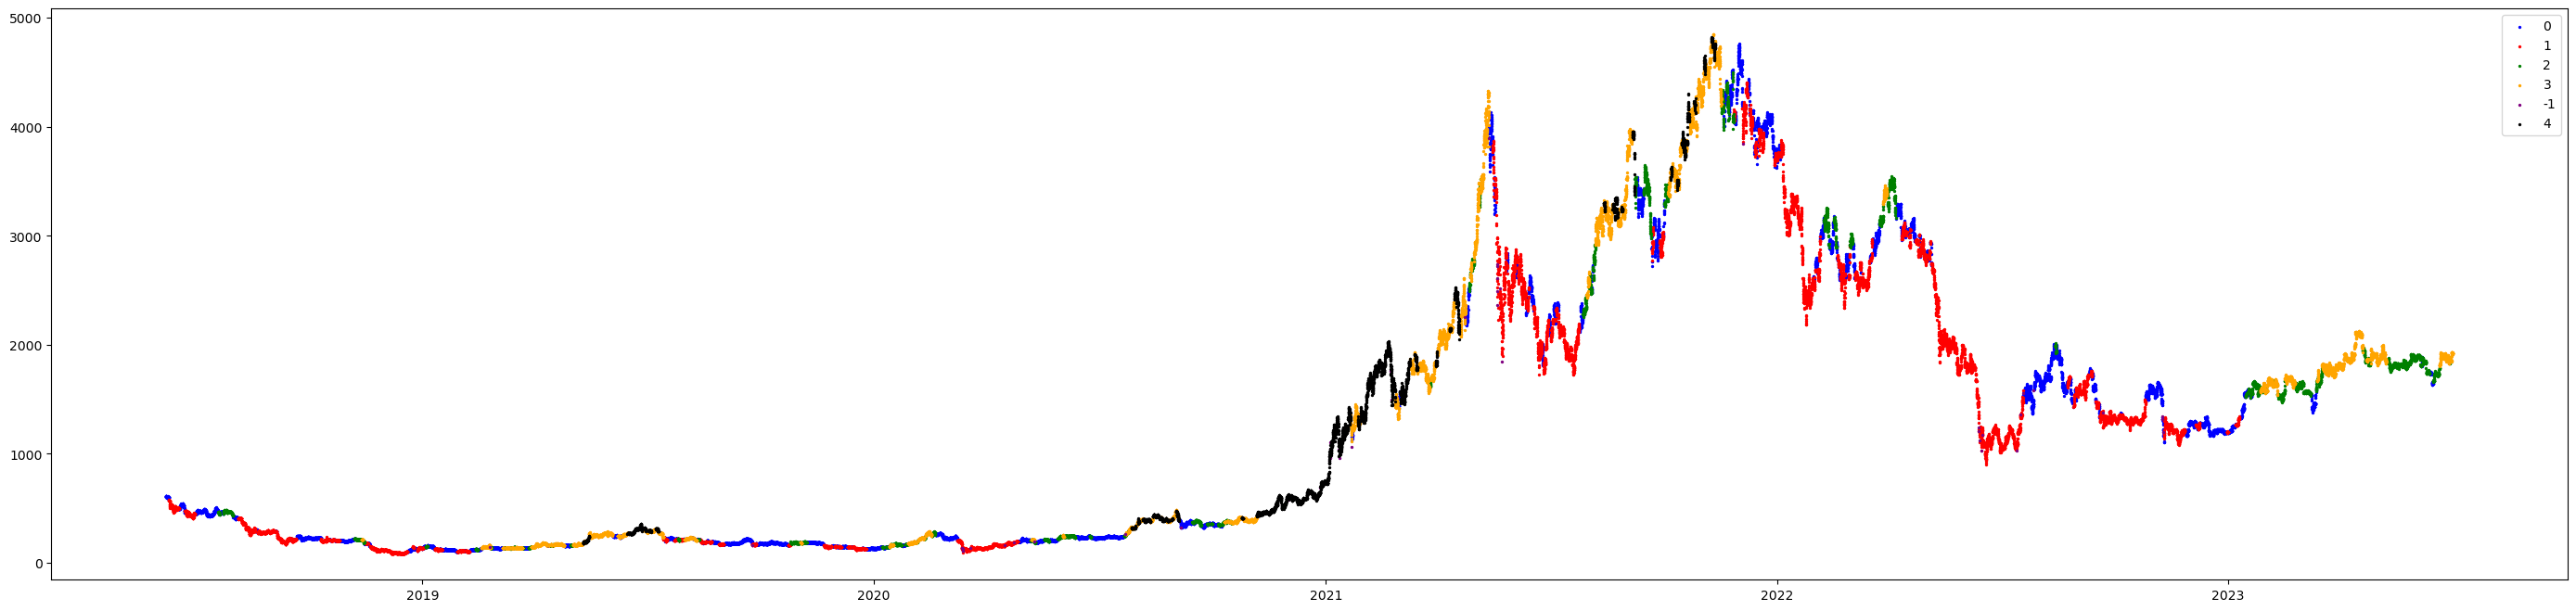

In [175]:
# Plot the time series with clusters in different colors
fig, ax = plt.subplots(figsize=(35, 8))
for label, color in zip(df_encoded['cluster'].unique(), ['blue', 'red', 'green', 'orange', 'purple','black','grey','yellow','magenta','cyan']):
    mask = df_encoded['cluster'] == label
    ax.scatter(df_encoded.index[mask], df_encoded['close'][mask], label=label, c=color, s=2)
ax.legend()
plt.show()

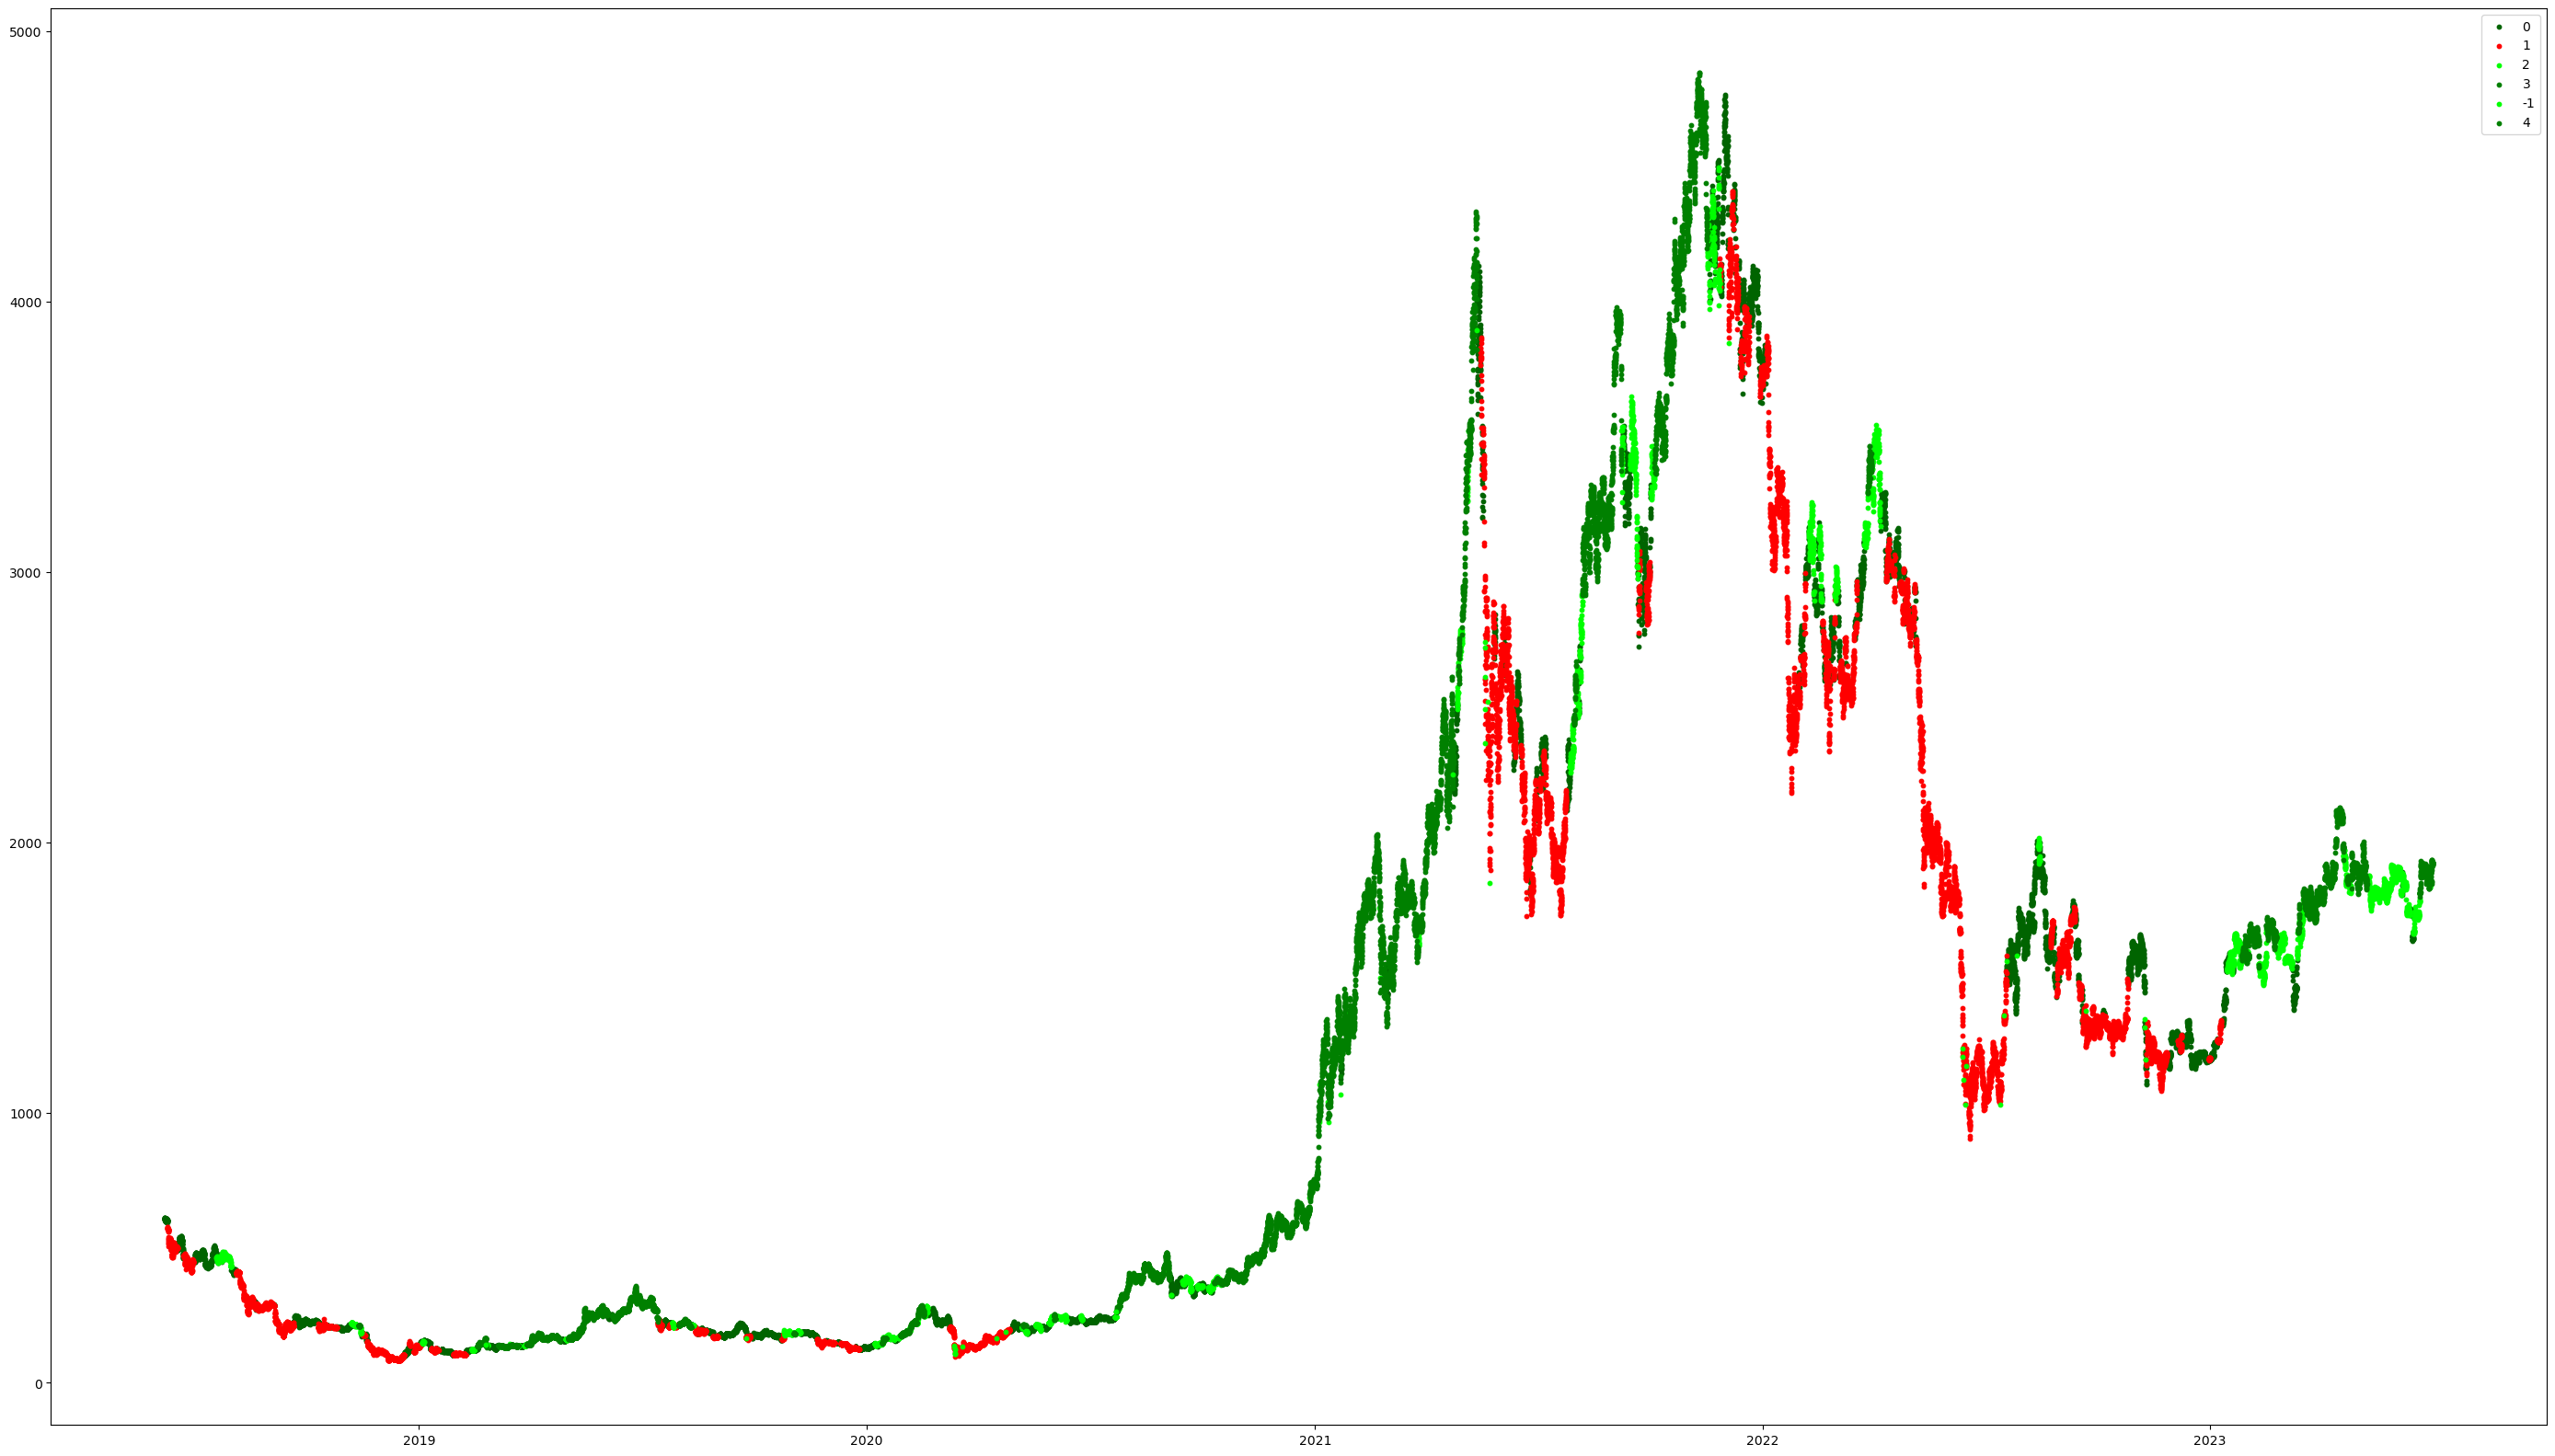

In [176]:
# Plot the time series with clusters in different colors
fig, ax = plt.subplots(figsize=(35, 20))
for label, color in zip(df_encoded['cluster'].unique(), ['darkgreen', 'red', 'lime', 'green', 'lime','green']):
    mask = df_encoded['cluster'] == label
    ax.scatter(df_encoded.index[mask], df_encoded['close'][mask], label=label, c=color, s=10)
ax.legend()
plt.show()

In [177]:
# Display the plot inline in Jupyter Lab
%matplotlib inline

# Create the scatter plot using hvplot.scatter
scatter = df_encoded.hvplot.scatter(x='index', y='close', by='cluster', legend='top')

# Set the plot options
scatter.opts(
    title='Time Series with Clusters',
    xlabel='Date',
    ylabel='Close Price',
    height=500,
    width=1000
)

# Show the plot
hvplot.show(scatter)

Launching server at http://localhost:56105


In [178]:
df_eda  = df_encoded


In [179]:
df_eda [['fng','fng_class','daily_returns','weekly_returns']] = df_eng [['fng','fng_class','daily_returns','weekly_returns']]

In [180]:
df_eda.columns

Index(['volume', 'ADX_100', 'fng_Fear', 'fng_Greed', 'fng_Hi_Fear',
       'fng_Hi_Greed', 'fng_Neutral', 'cluster', 'close', 'daily_returns',
       'fng', 'fng_class', 'weekly_returns'],
      dtype='object')

<Axes: xlabel='cluster', ylabel='fng'>

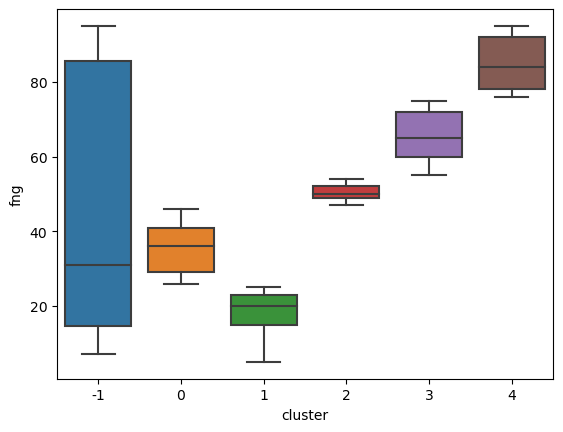

In [181]:
import seaborn as sns

# create a new DataFrame with just the relevant columns
cluster_df = df_eda[['cluster', 'fng', 'daily_returns','weekly_returns']]

# create boxplots of fng_value and actual_returns for each cluster
sns.boxplot(data=cluster_df, x='cluster', y='fng')


<Axes: xlabel='cluster', ylabel='weekly_returns'>

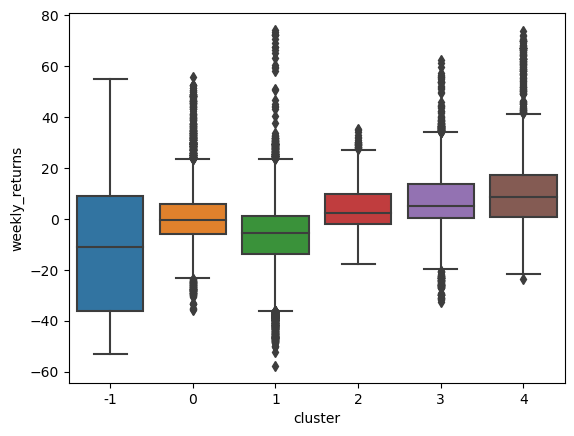

In [182]:
sns.boxplot(data=cluster_df, x='cluster', y='weekly_returns')

In [183]:
# Replace cluster labels -1 and 3 with 1, and the rest with 0
# df_eda['signal'] = np.where((df_eda['cluster']==-1) | (df_eda['cluster']==2)| (df_eda['cluster']==3 | (df_eda['cluster']==4)), 0, 1)

In [184]:
# Replace cluster labels -1 and 3 with 1, and the rest with 0
df_eda['signal'] = np.where(((df_eda['cluster']==3)
                             | (df_eda['cluster']==4 )
                             #| (df_eda['cluster']==2)
                             #| (df_eda['cluster']==-1)
                             ), 1, 0)

> keeping previous code : # Replace cluster labels -1 and 3 with 1, and the rest with 0
> df_eda['signal'] = np.where((df_eda['cluster']==-1) | (df_eda['cluster']==2)| (df_eda['cluster']==3 | (df_eda['cluster']==4)), 0, 1)

In [185]:
df_eda['signal'].unique()

array([0, 1])

In [186]:
df_eda['signal'].value_counts()

signal
0    31246
1    12979
Name: count, dtype: int64

In [187]:
df_eda.columns

Index(['volume', 'ADX_100', 'fng_Fear', 'fng_Greed', 'fng_Hi_Fear',
       'fng_Hi_Greed', 'fng_Neutral', 'cluster', 'close', 'daily_returns',
       'fng', 'fng_class', 'weekly_returns', 'signal'],
      dtype='object')

In [188]:
df_eda['signal'].loc[(df_eda['fng'] < 25) & (df_eda['weekly_returns'] > 0)] = 1 #25



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [189]:
df_eda['signal'].loc[(df_eda['fng'] > 85) & (df_eda['weekly_returns'] < 0)] = 0 #85
# df_eda['signal'].loc[(df_eda['fng'] > 90)] = 0


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


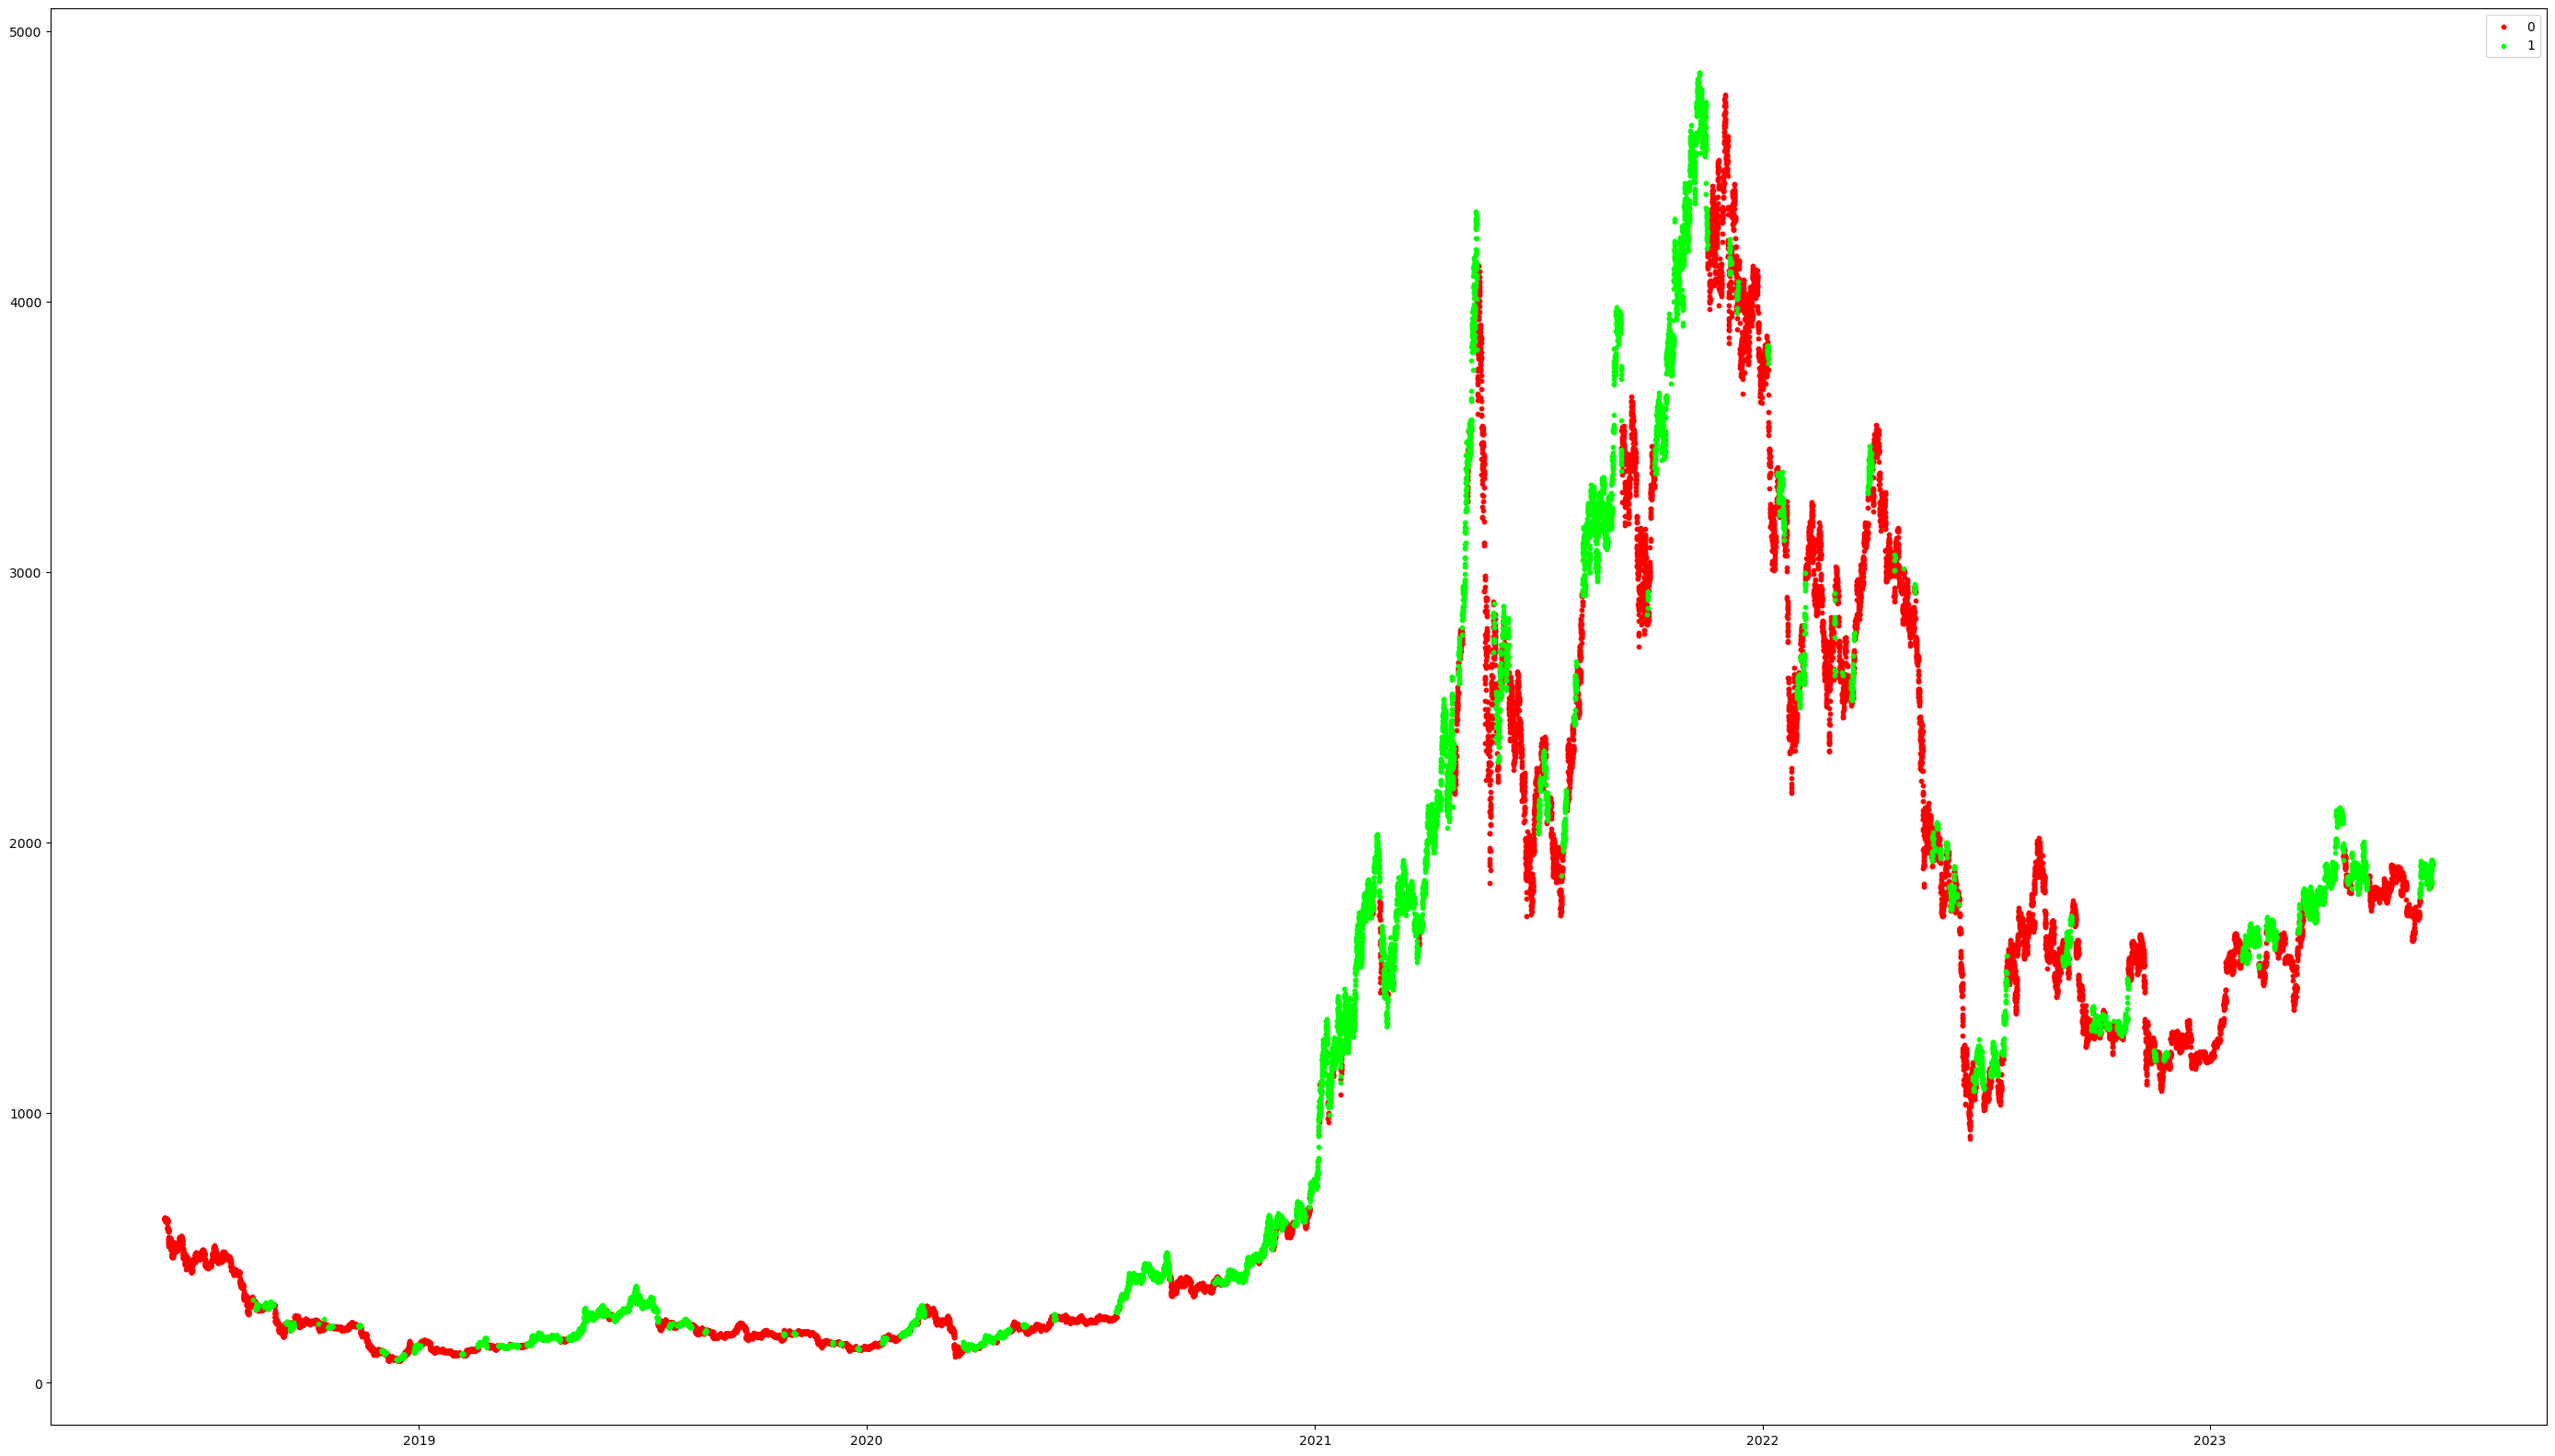

In [190]:
# Plot the time series with clusters in different colors
fig, ax = plt.subplots(figsize=(35, 20))
for label, color in zip(df_eda['signal'].unique(), ['red','lime']):
    mask = df_eda['signal'] == label
    ax.scatter(df_eda.index[mask], df_eda['close'][mask], label=label, c=color, s=10)
ax.legend()
plt.show()

In [191]:
# # Display the plot inline in Jupyter Lab
# %matplotlib inline

# # Plot the time series with clusters in different colors
# plot = df_encoded.hvplot.scatter(x='index', y='close',  c='cluster', legend='top_left', height=500, width=1000, title='Clusters of Time Series')

# # Show the plot in Jupyter notebook
# plot

In [192]:
# Set initial capital
initial_capital = float(10000)

# Set the share size
share_size = 500

# Buy a 500 share position when the dual moving average crossover Signal equals 1
# Otherwise, `Position` should be zero (sell)
df_eda['Position'] = share_size * df_eda['signal']

# Determine the points in time where a 500 share position is bought or sold
df_eda['Entry/Exit Position'] = df_eda['Position'].diff()

# Multiply the close price by the number of shares held, or the Position
df_eda['Portfolio Holdings'] = df_eda['close'] * df_eda['Position']

# Subtract the amount of either the cost or proceeds of the trade from the initial capital invested
df_eda['Portfolio Cash'] = initial_capital - (df_eda['close'] * df_eda['Entry/Exit Position']).cumsum() 

# Calculate the total portfolio value by adding the portfolio cash to the portfolio holdings (or investments)
df_eda['Portfolio Total'] = df_eda['Portfolio Cash'] + df_eda['Portfolio Holdings']

# Calculate the portfolio daily returns
df_eda['Portfolio Daily Returns'] = df_eda['Portfolio Total'].pct_change()

# Calculate the portfolio cumulative returns
df_eda['Portfolio Cumulative Returns'] = (1 + df_eda['Portfolio Daily Returns']).cumprod() - 1



In [193]:
# Visualize the value of the total portfolio
total_portfolio_value = df_eda[['Portfolio Total']].hvplot(
    line_color='lightgray',
    ylabel='Total Portfolio Value',
    xlabel='Date',
    width=1000,
    height=400
)


In [194]:

total_portfolio_value

:Curve   [index]   (Portfolio Total)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
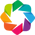

In [195]:
from bokeh.plotting import show
import hvplot.pandas
import holoviews as hv

hv.extension('bokeh')

show(hv.render(total_portfolio_value))

In [196]:
df_eda.head()

volume   ADX_100  fng_Fear  fng_Greed  fng_Hi_Fear  \
2018-06-07 07:00:00  2097.03849  7.922152      True      False        False   
2018-06-07 08:00:00  4142.71778  7.906581      True      False        False   
2018-06-07 09:00:00  2678.96166  7.884788      True      False        False   
2018-06-07 10:00:00  1989.56528  7.863214      True      False        False   
2018-06-07 11:00:00  1659.15096  7.841855      True      False        False   

                     fng_Hi_Greed  fng_Neutral  cluster   close  \
2018-06-07 07:00:00         False        False        0  609.58   
2018-06-07 08:00:00         False        False        0  608.18   
2018-06-07 09:00:00         False        False        0  609.64   
2018-06-07 10:00:00         False        False        0  607.99   
2018-06-07 11:00:00         False        False        0  607.60   

                     daily_returns  ...  fng_class weekly_returns  signal  \
2018-06-07 07:00:00       0.003738  ...       Fear       6.419232       0   
2018-06-07 08:00:00      -0.002297  ...       Fear       6.561772       0   
2018-06-07 09:00:00       0.002401  ...       Fear       6.606512       0   
2018-06-07 10:00:00      -0.002707  ...       Fear       6.414744       0   
2018-06-07 11:00:00      -0.000641  ...       Fear       5.682431       0   

                     Position  Entry/Exit Position  Portfolio Holdings  \
2018-06-07 07:00:00         0                  NaN                 0.0   
2018-06-07 08:00:00         0                  0.0                 0.0   
2018-06-07 09:00:00         0                  0.0                 0.0   
2018-06-07 10:00:00         0                  0.0                 0.0   
2018-06-07 11:00:00         0                  0.0                 0.0   

                     Portfolio Cash  Portfolio Total  Portfolio Daily Returns  \
2018-06-07 07:00:00             NaN              NaN                      NaN   
2018-06-07 08:00:00         10000.0          10000.0                      NaN   
2018-06-07 09:00:00         10000.0          10000.0                      0.0   
2018-06-07 10:00:00         10000.0          10000.0                      0.0   
2018-06-07 11:00:00         10000.0          10000.0                      0.0   

                     Portfolio Cumulative Returns  
2018-06-07 07:00:00                           NaN  
2018-06-07 08:00:00                           NaN  
2018-06-07 09:00:00                           0.0  
2018-06-07 10:00:00                           0.0  
2018-06-07 11:00:00                           0.0  

[5 rows x 21 columns]

---
## 2ND Feat Engineering

In [197]:
import finta as ft
from finta import TA
import talib

prep_df = df_eng.copy()
prep_df['signal'] = df_eda['signal']


In [198]:
prep_df.columns

Index(['fng', 'fng_class', 'open', 'high', 'low', 'close', 'volume',
       'daily_returns', 'Price', 'PiCycle', 'RUPL', 'RHODL', 'Puell', '2YMA',
       'Trolololo', 'MVRV', 'ReserveRisk', 'Woobull', 'CBBI', 'CBBI_class',
       'SMA_100', 'EMA_100', 'HMA_100', 'VAMA_100', 'ATR_100', 'ADX_100',
       'RSI_100', 'SMA_200', 'EMA_200', 'HMA_200', 'VAMA_200', 'ATR_200',
       'ADX_200', 'RSI_200', 'SMA_300', 'EMA_300', 'HMA_300', 'VAMA_300',
       'ATR_300', 'ADX_300', 'RSI_300', 'SMA_500', 'EMA_500', 'HMA_500',
       'VAMA_500', 'ATR_500', 'ADX_500', 'RSI_500', 'SMA_750', 'EMA_750',
       'HMA_750', 'VAMA_750', 'ATR_750', 'ADX_750', 'RSI_750', 'SMA_1000',
       'EMA_1000', 'HMA_1000', 'VAMA_1000', 'ATR_1000', 'ADX_1000', 'RSI_1000',
       'SMA_1500', 'EMA_1500', 'HMA_1500', 'VAMA_1500', 'ATR_1500', 'ADX_1500',
       'RSI_1500', 'UO', 'AO', 'OBV', 'CHAIKIN', 'BB_UPPER', 'BB_MED',
       'BB_LOWER', 'cci', 'tenkan_sen', 'kijun_sen', 'senkou_span_a',
       'senkou_span_b', 'chikou_

In [199]:
# Dummy-encoding process 
# create a list of categorical columns
cat_cols = ['fng_class']

# use the get_dummies function to dummy encode the categorical columns
dummy_cols = pd.get_dummies(prep_df[cat_cols], prefix=cat_cols, drop_first=True)

# concatenate the dummy columns with the original dataframe
prep_df = pd.concat([prep_df.drop(cat_cols, axis=1), dummy_cols], axis=1)

In [200]:
prep_df['signal'].value_counts()

signal
0    28557
1    15668
Name: count, dtype: int64

___
### 3.5 Class Imbalance

In [201]:
import pandas as pd
from sklearn.utils import resample

# Count the number of samples in each class
class_counts = prep_df['signal'].value_counts()

# Find the class with fewer samples
minority_class = class_counts.idxmin()

# Split the dataframe into the majority and minority classes
majority_class = prep_df[prep_df['signal'] != minority_class]
minority_class = prep_df[prep_df['signal'] == minority_class]

# Undersample the majority class to match the number of samples in the minority class
undersampled_majority = resample(majority_class,
                                 replace=False,
                                 n_samples=len(minority_class),
                                 random_state=42)

# Combine the undersampled majority class with the minority class
balanced_df = pd.concat([undersampled_majority, minority_class])

# Shuffle the rows in the balanced dataframe
balanced_df = balanced_df.sample(frac=1, random_state=42)

In [202]:
balanced_df["signal"].value_counts()

signal
0    15668
1    15668
Name: count, dtype: int64

In [203]:
balanced_df.columns

Index(['fng', 'open', 'high', 'low', 'close', 'volume', 'daily_returns',
       'Price', 'PiCycle', 'RUPL', 'RHODL', 'Puell', '2YMA', 'Trolololo',
       'MVRV', 'ReserveRisk', 'Woobull', 'CBBI', 'CBBI_class', 'SMA_100',
       'EMA_100', 'HMA_100', 'VAMA_100', 'ATR_100', 'ADX_100', 'RSI_100',
       'SMA_200', 'EMA_200', 'HMA_200', 'VAMA_200', 'ATR_200', 'ADX_200',
       'RSI_200', 'SMA_300', 'EMA_300', 'HMA_300', 'VAMA_300', 'ATR_300',
       'ADX_300', 'RSI_300', 'SMA_500', 'EMA_500', 'HMA_500', 'VAMA_500',
       'ATR_500', 'ADX_500', 'RSI_500', 'SMA_750', 'EMA_750', 'HMA_750',
       'VAMA_750', 'ATR_750', 'ADX_750', 'RSI_750', 'SMA_1000', 'EMA_1000',
       'HMA_1000', 'VAMA_1000', 'ATR_1000', 'ADX_1000', 'RSI_1000', 'SMA_1500',
       'EMA_1500', 'HMA_1500', 'VAMA_1500', 'ATR_1500', 'ADX_1500', 'RSI_1500',
       'UO', 'AO', 'OBV', 'CHAIKIN', 'BB_UPPER', 'BB_MED', 'BB_LOWER', 'cci',
       'tenkan_sen', 'kijun_sen', 'senkou_span_a', 'senkou_span_b',
       'chikou_span', 'weekl

In [204]:
# Creating X as predictors (features) dataset
X= balanced_df.copy()

# sort X by index
X = X.sort_index(axis=0)

# Removing columns indicative of previous prices
# & shifting X one row down to avoid using data not available to us at the time of prediction
X= X.drop(["open","high","low","close","volume","Price",
           "CBBI_class",
           "fng_class_Extreme Greed", "fng_class_Fear", "fng_class_Greed",
           "fng_class_Neutral",
           "daily_returns",#"weekly_returns",
           "signal"], axis =1).shift().dropna().copy()

In [205]:
X.columns

Index(['fng', 'PiCycle', 'RUPL', 'RHODL', 'Puell', '2YMA', 'Trolololo', 'MVRV',
       'ReserveRisk', 'Woobull', 'CBBI', 'SMA_100', 'EMA_100', 'HMA_100',
       'VAMA_100', 'ATR_100', 'ADX_100', 'RSI_100', 'SMA_200', 'EMA_200',
       'HMA_200', 'VAMA_200', 'ATR_200', 'ADX_200', 'RSI_200', 'SMA_300',
       'EMA_300', 'HMA_300', 'VAMA_300', 'ATR_300', 'ADX_300', 'RSI_300',
       'SMA_500', 'EMA_500', 'HMA_500', 'VAMA_500', 'ATR_500', 'ADX_500',
       'RSI_500', 'SMA_750', 'EMA_750', 'HMA_750', 'VAMA_750', 'ATR_750',
       'ADX_750', 'RSI_750', 'SMA_1000', 'EMA_1000', 'HMA_1000', 'VAMA_1000',
       'ATR_1000', 'ADX_1000', 'RSI_1000', 'SMA_1500', 'EMA_1500', 'HMA_1500',
       'VAMA_1500', 'ATR_1500', 'ADX_1500', 'RSI_1500', 'UO', 'AO', 'OBV',
       'CHAIKIN', 'BB_UPPER', 'BB_MED', 'BB_LOWER', 'cci', 'tenkan_sen',
       'kijun_sen', 'senkou_span_a', 'senkou_span_b', 'chikou_span',
       'weekly_returns', 'price_slope'],
      dtype='object')

In [206]:
# Calculate correlation matrix
# calculate the correlation matrix of the features
corr_matrix = X.corr()

# set the threshold for correlation value
corr_threshold = 0.60

# find the highly correlated features and drop them from the dataframe
high_corr_features = np.where(corr_matrix.abs() > corr_threshold)
high_corr_features = [(corr_matrix.columns[x], corr_matrix.columns[y]) for x, y in zip(*high_corr_features) if x != y and x < y]
X.drop([col[1] for col in high_corr_features], axis=1, inplace=True)

# select the remaining features with low correlation
low_corr_features = X.columns.tolist()

# print the low correlated features
print(low_corr_features)

['fng', 'PiCycle', 'SMA_100', 'ADX_100', 'RSI_100', 'UO', 'AO', 'price_slope']


In [207]:
X = X[low_corr_features]

In [208]:
X

fng  PiCycle    SMA_100   ADX_100    RSI_100         UO  \
2018-06-07 10:00:00  38.0   0.5114   604.2819  7.922152  51.864578  50.363159   
2018-06-07 11:00:00  38.0   0.5114   604.6001  7.863214  51.618827  44.739307   
2018-06-07 12:00:00  38.0   0.5114   604.6068  7.841855  51.561560  45.688991   
2018-06-07 13:00:00  38.0   0.5114   604.4606  7.827675  51.808043  46.916350   
2018-06-07 14:00:00  38.0   0.5114   604.3119  7.813742  51.639542  46.365875   
...                   ...      ...        ...       ...        ...        ...   
2023-07-01 18:00:00  59.0   0.5826  1877.8559  9.241540  53.938355  49.694721   
2023-07-01 19:00:00  59.0   0.5826  1878.2246  9.258600  54.169424  54.495590   
2023-07-01 20:00:00  59.0   0.5826  1878.7346  9.279808  54.274671  50.076230   
2023-07-01 21:00:00  59.0   0.5826  1878.8720  9.300804  54.290496  53.076282   
2023-07-01 22:00:00  59.0   0.5826  1879.0834  9.321204  54.295289  53.820028   

                            AO  price_slope  
2018-06-07 10:00:00   4.206912     0.000107  
2018-06-07 11:00:00   2.213676     0.000107  
2018-06-07 12:00:00   2.060029     0.000107  
2018-06-07 13:00:00   2.126676     0.000107  
2018-06-07 14:00:00   1.784647     0.000107  
...                        ...          ...  
2023-07-01 18:00:00  10.358029     0.000107  
2023-07-01 19:00:00   8.135529     0.000107  
2023-07-01 20:00:00   6.911382     0.000107  
2023-07-01 21:00:00   6.329176     0.000107  
2023-07-01 22:00:00   5.764706     0.000107  

[31335 rows x 8 columns]

In [209]:
# Copy the new signal column to a new Series called y.
y = balanced_df["signal"].copy()

# keeping y and X the same size 
y = y[X.index]

In [210]:
y

2018-06-07 10:00:00    0
2018-06-07 11:00:00    0
2018-06-07 12:00:00    0
2018-06-07 13:00:00    0
2018-06-07 14:00:00    0
                      ..
2023-07-01 18:00:00    1
2023-07-01 19:00:00    1
2023-07-01 20:00:00    1
2023-07-01 21:00:00    1
2023-07-01 22:00:00    1
Name: signal, Length: 31335, dtype: int64

---
## ML Scaler

In [211]:
from sklearn.preprocessing import StandardScaler

# Scale the data
MLscaler = StandardScaler()
X_scaled = MLscaler.fit_transform(X)

# Convert the scaled numpy array back to a pandas DataFrame
X_scaled = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)

In [212]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object
scaler = StandardScaler()

# Scale the data
X_scaled = scaler.fit_transform(X)

# Convert X_scaled back to a DataFrame
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Create a logistic regression model
model = LogisticRegression(max_iter=200)

# Create an RFE model to select the best features
rfe = RFE(model, n_features_to_select=25)

# Fit the RFE model to the data
rfe = rfe.fit(X_scaled, y)

# Get the selected features
selected_features = X_scaled.columns[rfe.support_]

# Keep only specified columns in the dataframe
X_scaled = X_scaled[selected_features]

# Print the selected features
print("Number of selected features:", len(X_scaled.columns), "\nSelected features:\n", selected_features)


Number of selected features: 8 
Selected features:
 Index(['fng', 'PiCycle', 'SMA_100', 'ADX_100', 'RSI_100', 'UO', 'AO',
       'price_slope'],
      dtype='object')


In [213]:
df_lo_feats = X[selected_features].copy()
#df_lo_feats = df_lo_feats.drop(["fng_value"], axis =1)
# Calculate correlation matrix
# calculate the correlation matrix of the features
corr_matrix = df_lo_feats.corr()

# set the threshold for correlation value
corr_threshold = 0.90

# find the highly correlated features and drop them from the dataframe
high_corr_features = np.where(corr_matrix.abs() > corr_threshold)
high_corr_features = [(corr_matrix.columns[x], corr_matrix.columns[y]) for x, y in zip(*high_corr_features) if x != y and x < y]
df_lo_feats.drop([col[1] for col in high_corr_features], axis=1, inplace=True)

# select the remaining features with low correlation
low_corr_features = df_lo_feats.columns.tolist()

# print the low correlated features
print(low_corr_features)

['fng', 'PiCycle', 'SMA_100', 'ADX_100', 'RSI_100', 'UO', 'AO', 'price_slope']


In [214]:
X=df_lo_feats[low_corr_features]
#X = X[selected_features]

In [215]:
# Imports 
from pandas.tseries.offsets import DateOffset

# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
#print(training_begin)

# Select the ending period for the training data with an offset of 36 months
training_end = X.index.min() + DateOffset(months=36)

# Display the training end date
#print(training_end)

# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Display sample data
display(X_train.head())

# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

# Display sample data
display(X_test.head())

fng  PiCycle   SMA_100   ADX_100    RSI_100         UO  \
2018-06-07 10:00:00  38.0   0.5114  604.2819  7.922152  51.864578  50.363159   
2018-06-07 11:00:00  38.0   0.5114  604.6001  7.863214  51.618827  44.739307   
2018-06-07 12:00:00  38.0   0.5114  604.6068  7.841855  51.561560  45.688991   
2018-06-07 13:00:00  38.0   0.5114  604.4606  7.827675  51.808043  46.916350   
2018-06-07 14:00:00  38.0   0.5114  604.3119  7.813742  51.639542  46.365875   

                           AO  price_slope  
2018-06-07 10:00:00  4.206912     0.000107  
2018-06-07 11:00:00  2.213676     0.000107  
2018-06-07 12:00:00  2.060029     0.000107  
2018-06-07 13:00:00  2.126676     0.000107  
2018-06-07 14:00:00  1.784647     0.000107

fng  PiCycle    SMA_100   ADX_100    RSI_100         UO  \
2021-06-07 10:00:00  15.0   0.9091  2719.7863  7.660298  52.180760  55.870050   
2021-06-07 11:00:00  15.0   0.9091  2719.5801  7.598173  52.929145  60.634759   
2021-06-07 12:00:00  15.0   0.9091  2719.5034  7.536668  52.654750  62.200121   
2021-06-07 13:00:00  15.0   0.9091  2719.4531  7.471307  52.990798  62.412955   
2021-06-07 14:00:00  15.0   0.9091  2718.5993  7.418349  52.136299  56.573198   

                            AO  price_slope  
2021-06-07 10:00:00  52.048441     0.000107  
2021-06-07 11:00:00  53.664412     0.000107  
2021-06-07 12:00:00  57.404529     0.000107  
2021-06-07 13:00:00  67.084559     0.000107  
2021-06-07 14:00:00  74.233824     0.000107

In [216]:
## Scaler for ML pre-processing

In [217]:
# Create a StandardScaler instance
scaler = StandardScaler()
 
# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)
 
# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

---
## 4. ML models 
#### 4.1 XGboost

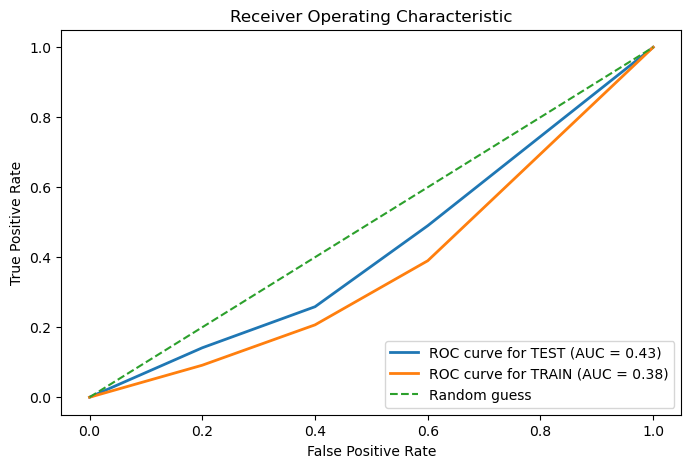

TRAINING classification report: 
               precision    recall  f1-score   support

           0       0.18      0.08      0.11      8697
           1       0.48      0.71      0.57     10360

    accuracy                           0.42     19057
   macro avg       0.33      0.39      0.34     19057
weighted avg       0.34      0.42      0.36     19057


TESTING classification report: 
               precision    recall  f1-score   support

           0       0.43      0.17      0.25      6970
           1       0.39      0.70      0.50      5309

    accuracy                           0.40     12279
   macro avg       0.41      0.44      0.37     12279
weighted avg       0.41      0.40      0.36     12279

Test accuracy: 0.40
>> Test precision: 0.40 <<
Test recall: 0.40
Test F1 score: 0.40
Test AUC score: 0.43


In [218]:
import xgboost as xgb
#from xgboost import xgbClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV

#replace -1 by 0 as xgboost expects a boolean target vector (only 0 and 1)
y_train = y_train.replace(-1, 0)
y_test = y_test.replace(-1, 0)

# Create a xgb Classifier model
xgb_clf = xgb.XGBClassifier(reg_alpha=10)

xgb_clf.fit(X_train_scaled, y_train) 

# Use the best model to make predictions on the test data
y_pred_xgb = xgb_clf.predict(X_test_scaled)

ROC(xgb_clf,X_train,X_test,y_train,y_test)

<Axes: >

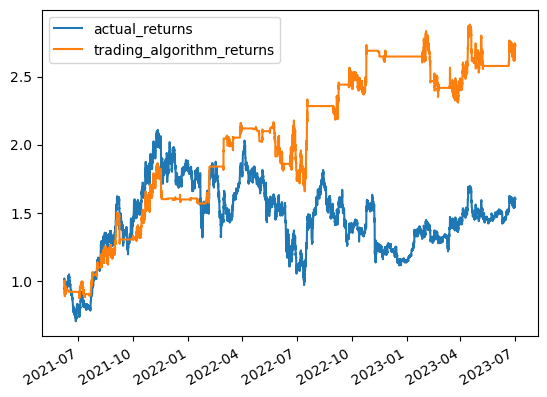

In [219]:
# Define the trading fee as a decimal
trading_fee = 0.00075
classifier = xgb_clf

# Backtest using our exteranl function
xgb_predictions_df = Backtesting (prep_df, X_test, X_test_scaled, classifier,trading_fee)

# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + xgb_predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot()

> The XGB results appear to be too good to be true - the classification report are very weird as well --> not to use for production

In [220]:
X_test.columns


Index(['fng', 'PiCycle', 'SMA_100', 'ADX_100', 'RSI_100', 'UO', 'AO',
       'price_slope'],
      dtype='object')

---
#### 4.2 CatBoost

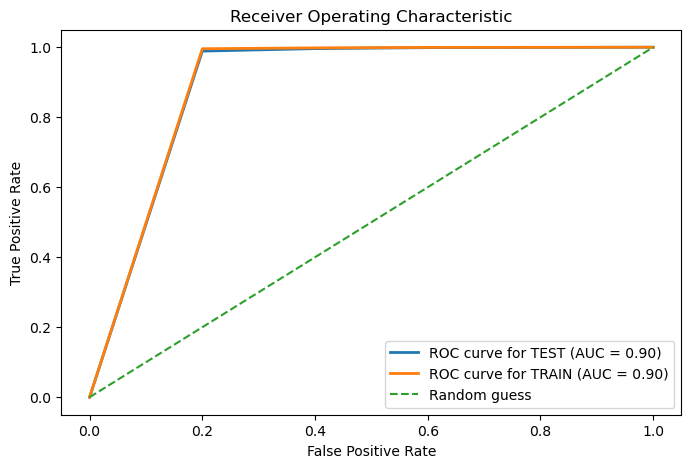

TRAINING classification report: 
               precision    recall  f1-score   support

           0       0.96      0.93      0.95      8697
           1       0.95      0.96      0.96     10360

    accuracy                           0.95     19057
   macro avg       0.95      0.95      0.95     19057
weighted avg       0.95      0.95      0.95     19057


TESTING classification report: 
               precision    recall  f1-score   support

           0       0.94      0.94      0.94      6970
           1       0.93      0.93      0.93      5309

    accuracy                           0.94     12279
   macro avg       0.93      0.93      0.93     12279
weighted avg       0.94      0.94      0.94     12279

Test accuracy: 0.94
>> Test precision: 0.94 <<
Test recall: 0.94
Test F1 score: 0.94
Test AUC score: 0.90


In [221]:
# Import libraries
from catboost import CatBoostClassifier
# Initialize the CatBoost model

cb_clf = CatBoostClassifier(
    iterations=300,
    learning_rate=.001,
    depth=5,
    l2_leaf_reg=.001,  # L2 regularization parameter
    verbose=False
)

# Train the model on the training data
cb_clf.fit(X_train_scaled, y_train)

# display ROC and classification metrics 
ROC(cb_clf,X_train_scaled, X_test_scaled, y_train, y_test)


<Axes: >

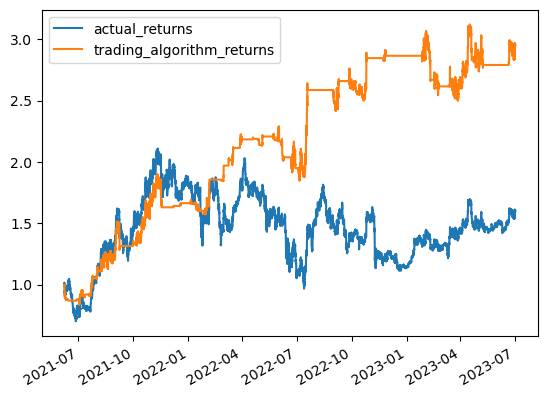

In [222]:
# Define the trading fee as a decimal
trading_fee = 0.00075
classifier = cb_clf

# Backtest using our exteranl function
cb_predictions_df = Backtesting (df_eda, X_test, X_test_scaled, classifier,trading_fee)

# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + cb_predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot()

---
#### 4.3 LDA

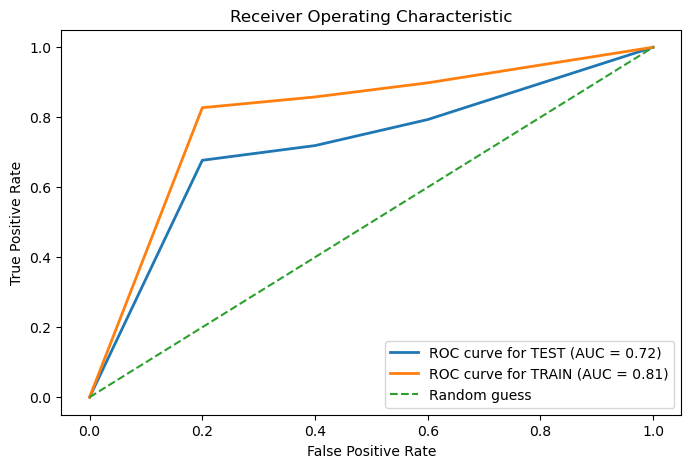

TRAINING classification report: 
               precision    recall  f1-score   support

           0       0.80      0.81      0.80      8697
           1       0.84      0.82      0.83     10360

    accuracy                           0.82     19057
   macro avg       0.82      0.82      0.82     19057
weighted avg       0.82      0.82      0.82     19057


TESTING classification report: 
               precision    recall  f1-score   support

           0       0.71      0.35      0.47      6970
           1       0.49      0.82      0.61      5309

    accuracy                           0.55     12279
   macro avg       0.60      0.58      0.54     12279
weighted avg       0.62      0.55      0.53     12279

Test accuracy: 0.55
>> Test precision: 0.55 <<
Test recall: 0.55
Test F1 score: 0.55
Test AUC score: 0.72


In [223]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# create LDA object and fit the model
lda = LinearDiscriminantAnalysis()

# Train the model on the training data
lda.fit_transform(X_train_scaled, y_train)

ROC(lda,X_train_scaled, X_test_scaled, y_train, y_test)

<Axes: >

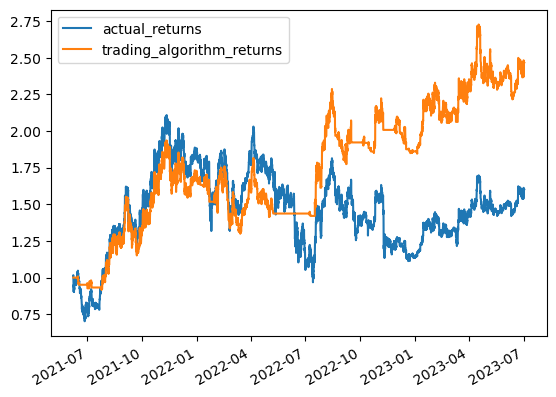

In [224]:
# Define the trading fee as a decimal
trading_fee = 0.00075
classifier = lda

# Backtest using our exteranl function
lda_predictions_df = Backtesting (prep_df, X_test, X_test_scaled, classifier,trading_fee)

# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + lda_predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot()

## 4.4 Gradient Boosting Tree Classifier

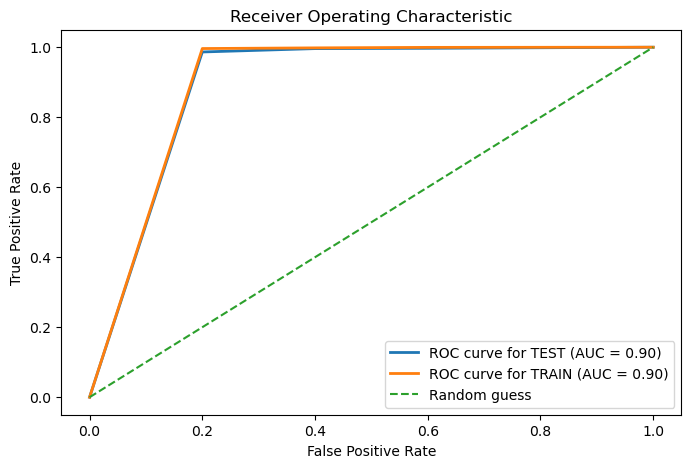

TRAINING classification report: 
               precision    recall  f1-score   support

           0       0.96      0.93      0.95      8697
           1       0.95      0.97      0.96     10360

    accuracy                           0.95     19057
   macro avg       0.95      0.95      0.95     19057
weighted avg       0.95      0.95      0.95     19057


TESTING classification report: 
               precision    recall  f1-score   support

           0       0.95      0.93      0.94      6970
           1       0.91      0.94      0.93      5309

    accuracy                           0.93     12279
   macro avg       0.93      0.94      0.93     12279
weighted avg       0.94      0.93      0.94     12279

Test accuracy: 0.93
>> Test precision: 0.93 <<
Test recall: 0.93
Test F1 score: 0.93
Test AUC score: 0.90


In [225]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Initialize the model with regularization
gbt_clf = GradientBoostingClassifier(
    learning_rate = .01, 
    subsample = .1, 
    max_depth=3, 
    #min_samples_split=10, 
    #min_samples_leaf=10, 
    #max_leaf_nodes=None, 
    random_state=seed
    )

# Train the model on the training data
gbt_clf.fit(X_train_scaled, y_train)

ROC(gbt_clf,X_train_scaled, X_test_scaled, y_train, y_test)


<Axes: >

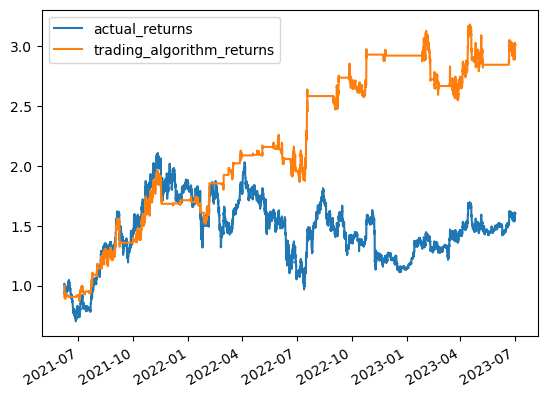

In [226]:
# Define the trading fee as a decimal
trading_fee = 0.00075
classifier = gbt_clf

# Backtest using our exteranl function
gbt_predictions_df = Backtesting (prep_df, X_test, X_test_scaled, classifier,trading_fee)

# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + gbt_predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot()

In [227]:
display (df_eda.head())
display (gbt_predictions_df.head())

volume   ADX_100  fng_Fear  fng_Greed  fng_Hi_Fear  \
2018-06-07 07:00:00  2097.03849  7.922152      True      False        False   
2018-06-07 08:00:00  4142.71778  7.906581      True      False        False   
2018-06-07 09:00:00  2678.96166  7.884788      True      False        False   
2018-06-07 10:00:00  1989.56528  7.863214      True      False        False   
2018-06-07 11:00:00  1659.15096  7.841855      True      False        False   

                     fng_Hi_Greed  fng_Neutral  cluster   close  \
2018-06-07 07:00:00         False        False        0  609.58   
2018-06-07 08:00:00         False        False        0  608.18   
2018-06-07 09:00:00         False        False        0  609.64   
2018-06-07 10:00:00         False        False        0  607.99   
2018-06-07 11:00:00         False        False        0  607.60   

                     daily_returns  ...  fng_class weekly_returns  signal  \
2018-06-07 07:00:00       0.003738  ...       Fear       6.419232       0   
2018-06-07 08:00:00      -0.002297  ...       Fear       6.561772       0   
2018-06-07 09:00:00       0.002401  ...       Fear       6.606512       0   
2018-06-07 10:00:00      -0.002707  ...       Fear       6.414744       0   
2018-06-07 11:00:00      -0.000641  ...       Fear       5.682431       0   

                     Position  Entry/Exit Position  Portfolio Holdings  \
2018-06-07 07:00:00         0                  NaN                 0.0   
2018-06-07 08:00:00         0                  0.0                 0.0   
2018-06-07 09:00:00         0                  0.0                 0.0   
2018-06-07 10:00:00         0                  0.0                 0.0   
2018-06-07 11:00:00         0                  0.0                 0.0   

                     Portfolio Cash  Portfolio Total  Portfolio Daily Returns  \
2018-06-07 07:00:00             NaN              NaN                      NaN   
2018-06-07 08:00:00         10000.0          10000.0                      NaN   
2018-06-07 09:00:00         10000.0          10000.0                      0.0   
2018-06-07 10:00:00         10000.0          10000.0                      0.0   
2018-06-07 11:00:00         10000.0          10000.0                      0.0   

                     Portfolio Cumulative Returns  
2018-06-07 07:00:00                           NaN  
2018-06-07 08:00:00                           NaN  
2018-06-07 09:00:00                           0.0  
2018-06-07 10:00:00                           0.0  
2018-06-07 11:00:00                           0.0  

[5 rows x 21 columns]

predicted_signal  actual_returns  \
2021-06-07 10:00:00                 1        0.014616   
2021-06-07 11:00:00                 1       -0.004749   
2021-06-07 12:00:00                 1        0.006513   
2021-06-07 13:00:00                 1       -0.014794   
2021-06-07 14:00:00                 1       -0.004249   

                     trading_algorithm_returns  
2021-06-07 10:00:00                        NaN  
2021-06-07 11:00:00                  -0.004749  
2021-06-07 12:00:00                   0.006513  
2021-06-07 13:00:00                  -0.014794  
2021-06-07 14:00:00                  -0.004249

In [228]:
display(len(df_eda),len(gbt_predictions_df))

44225

12279

In [229]:
df = gbt_predictions_df

In [230]:
df['close'] = df_eda['close']

In [231]:
# Rename column 'predicted_signal' to 'gbt_prediction'
df = df.rename(columns={'predicted_signal': 'gbt_prediction'})

In [232]:
df.head()

gbt_prediction  actual_returns  \
2021-06-07 10:00:00               1        0.014616   
2021-06-07 11:00:00               1       -0.004749   
2021-06-07 12:00:00               1        0.006513   
2021-06-07 13:00:00               1       -0.014794   
2021-06-07 14:00:00               1       -0.004249   

                     trading_algorithm_returns    close  
2021-06-07 10:00:00                        NaN  2826.07  
2021-06-07 11:00:00                  -0.004749  2812.65  
2021-06-07 12:00:00                   0.006513  2830.97  
2021-06-07 13:00:00                  -0.014794  2789.09  
2021-06-07 14:00:00                  -0.004249  2777.24

In [233]:
import pandas as pd
import numpy as np
import hvplot.pandas

# init
initial_capital = 10000
duration_dca_buy = 10
duration_dca_sell = 3
fee = 0.75/100 # 0.75% fee Kucoin

# Add new columns to store calculations
df['eth_owned'] = 0.0
df['current_usd_capital'] = initial_capital
df['algo_value'] = 0.0
df['dca_value'] = 0.0
df['dca_eth_owned'] = 0.0

# Initialize the remaining buy and sell duration
remaining_buy_duration = duration_dca_buy
remaining_sell_duration = 0

# Calculate the daily_buy_amount for DCA strategy
daily_dca_buy_amount = initial_capital / duration_dca_buy

# Loop through each row in the dataset
for i in range(1, len(df)):
    eth_owned = df.loc[df.index[i - 1], 'eth_owned']
    current_usd_capital = df.loc[df.index[i - 1], 'current_usd_capital']
    dca_eth_owned = df.loc[df.index[i - 1], 'dca_eth_owned']
    
    if df.loc[df.index[i], 'gbt_prediction'] == 1:
        if remaining_buy_duration > 0:
            # Calculate the daily_buy_amount based on the remaining buy duration
            daily_buy_amount = current_usd_capital / remaining_buy_duration
            remaining_buy_duration -= 1
        else:
            daily_buy_amount = 0

        # Buy using dollar-cost averaging
        if df.loc[df.index[i], 'close'] > 0:
            eth_to_buy = daily_buy_amount * (1-fee)/ df.loc[df.index[i], 'close']
            eth_owned += eth_to_buy
            current_usd_capital -= daily_buy_amount
        
            # Update daily_sell_amount
            daily_sell_amount = (eth_owned * df.loc[df.index[i], 'close']) / duration_dca_sell
        
    elif df.loc[df.index[i], 'gbt_prediction'] == 0 and eth_owned > 0:
        # Reset remaining_buy_duration
        remaining_buy_duration = duration_dca_buy
        
        # Sell using dollar-cost averaging
        if df.loc[df.index[i], 'close'] > 0:
            eth_to_sell = daily_sell_amount * (1-fee) / df.loc[df.index[i], 'close']
            eth_owned -= eth_to_sell
            current_usd_capital += daily_sell_amount 

    df.loc[df.index[i], 'eth_owned'] = eth_owned
    df.loc[df.index[i], 'current_usd_capital'] = current_usd_capital
    df.loc[df.index[i], 'algo_value'] = eth_owned * df.loc[df.index[i], 'close'] + current_usd_capital
    
    # Update DCA value and DCA ETH holdings
    if df.loc[df.index[i], 'close'] > 0:
        if initial_capital > 0:
            dca_eth_to_buy = daily_dca_buy_amount / df.loc[df.index[i], 'close']
            dca_eth_owned += dca_eth_to_buy
            initial_capital -= daily_dca_buy_amount
        else:
            dca_eth_to_buy = 0
            daily_dca_buy_amount = 0

        df.loc[df.index[i], 'dca_eth_owned'] = dca_eth_owned
        df.loc[df.index[i], 'dca_value'] = dca_eth_owned * df.loc[df.index[i], 'close']




In [234]:

# Plot the results
plot = df[['algo_value','dca_value']].hvplot.line(title='Algo-Trading with DCA_Strategy vs. DCA-ETH', width=1000, height=400)
plot


:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [249]:
plot = (1 + gbt_predictions_df[["trading_algorithm_returns", "actual_returns"]]).cumprod().hvplot.line(title='ETH HODL returns vs Algo-Trading w/o DCA',width=1100, height=400)
plot

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [246]:
import pandas as pd
import numpy as np
import hvplot.pandas

# init
initial_capital = 10000
duration_dca_buy = 10
duration_dca_sell = 3
fee = 0.75/100 # 0.75% fee Kucoin

df_noML = gbt_predictions_df.copy()
df_noML ['signal'] = prep_df['signal'].shift()

# Add new columns to store calculations
df_noML['eth_owned'] = 0.0
df_noML['current_usd_capital'] = initial_capital
df_noML['algo_value'] = 0.0
df_noML['dca_value'] = 0.0
df_noML['dca_eth_owned'] = 0.0

# Initialize the remaining buy and sell duration
remaining_buy_duration = duration_dca_buy
remaining_sell_duration = 0

# Calculate the daily_buy_amount for DCA strategy
daily_dca_buy_amount = initial_capital / duration_dca_buy

# Loop through each row in the dataset
for i in range(1, len(df)):
    eth_owned = df_noML.loc[df.index[i - 1], 'eth_owned']
    current_usd_capital = df_noML.loc[df.index[i - 1], 'current_usd_capital']
    dca_eth_owned = df_noML.loc[df_noML.index[i - 1], 'dca_eth_owned']
    
    if df_noML.loc[df_noML.index[i], 'signal'] == 1:
        if remaining_buy_duration > 0:
            # Calculate the daily_buy_amount based on the remaining buy duration
            daily_buy_amount = current_usd_capital / remaining_buy_duration
            remaining_buy_duration -= 1
        else:
            daily_buy_amount = 0

        # Buy using dollar-cost averaging
        if df_noML.loc[df_noML.index[i], 'close'] > 0:
            eth_to_buy = daily_buy_amount * (1-fee)/ df.loc[df.index[i], 'close']
            eth_owned += eth_to_buy
            current_usd_capital -= daily_buy_amount
        
            # Update daily_sell_amount
            daily_sell_amount = (eth_owned * df_noML.loc[df_noML.index[i], 'close']) / duration_dca_sell
        
    elif df_noML.loc[df_noML.index[i], 'signal'] == 0 and eth_owned > 0:
        # Reset remaining_buy_duration
        remaining_buy_duration = duration_dca_buy
        
        # Sell using dollar-cost averaging
        if df_noML.loc[df_noML.index[i], 'close'] > 0:
            eth_to_sell = daily_sell_amount * (1-fee) / df_noML.loc[df_noML.index[i], 'close']
            eth_owned -= eth_to_sell
            current_usd_capital += daily_sell_amount 

    df_noML.loc[df_noML.index[i], 'eth_owned'] = eth_owned
    df_noML.loc[df_noML.index[i], 'current_usd_capital'] = current_usd_capital
    df_noML.loc[df_noML.index[i], 'algo_value'] = eth_owned * df_noML.loc[df_noML.index[i], 'close'] + current_usd_capital
    
    # Update DCA value and DCA ETH holdings
    if df_noML.loc[df_noML.index[i], 'close'] > 0:
        if initial_capital > 0:
            dca_eth_to_buy = daily_dca_buy_amount / df_noML.loc[df_noML.index[i], 'close']
            dca_eth_owned += dca_eth_to_buy
            initial_capital -= daily_dca_buy_amount
        else:
            dca_eth_to_buy = 0
            daily_dca_buy_amount = 0

        df_noML.loc[df_noML.index[i], 'dca_eth_owned'] = dca_eth_owned
        df_noML.loc[df_noML.index[i], 'dca_value'] = dca_eth_owned * df_noML.loc[df_noML.index[i], 'close']




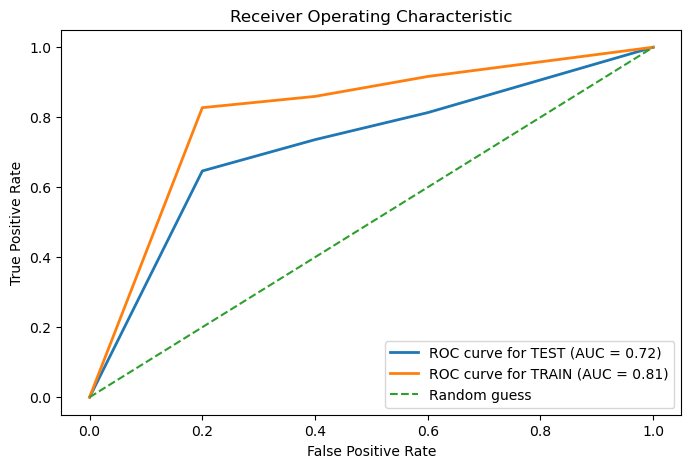

TRAINING classification report: 
               precision    recall  f1-score   support

           0       0.80      0.79      0.79      8697
           1       0.83      0.83      0.83     10360

    accuracy                           0.81     19057
   macro avg       0.81      0.81      0.81     19057
weighted avg       0.81      0.81      0.81     19057


TESTING classification report: 
               precision    recall  f1-score   support

           0       0.79      0.31      0.45      6970
           1       0.50      0.89      0.64      5309

    accuracy                           0.56     12279
   macro avg       0.64      0.60      0.54     12279
weighted avg       0.66      0.56      0.53     12279

Test accuracy: 0.56
>> Test precision: 0.56 <<
Test recall: 0.56
Test F1 score: 0.56
Test AUC score: 0.72


In [236]:
# create the logistic regression model
lr_model = LogisticRegression()

# fit the model on the training data
lr_model.fit(X_train_scaled, y_train)

# display ROC curve and classification results
ROC(lr_model,X_train_scaled,X_test_scaled,y_train,y_test)

<Axes: >

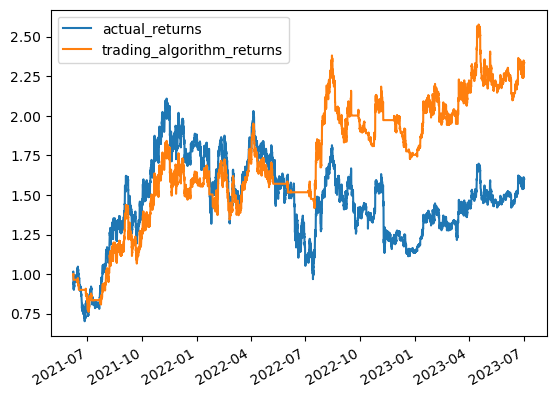

In [237]:
# Define the trading fee as a decimal
trading_fee = 0.00075
classifier = lr_model

# Backtest using our exteranl function
lr_predictions_df = Backtesting (prep_df, X_test, X_test_scaled, classifier,trading_fee)

# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + lr_predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot()

In [238]:
## Adding Short and Long strategy 

<Axes: >

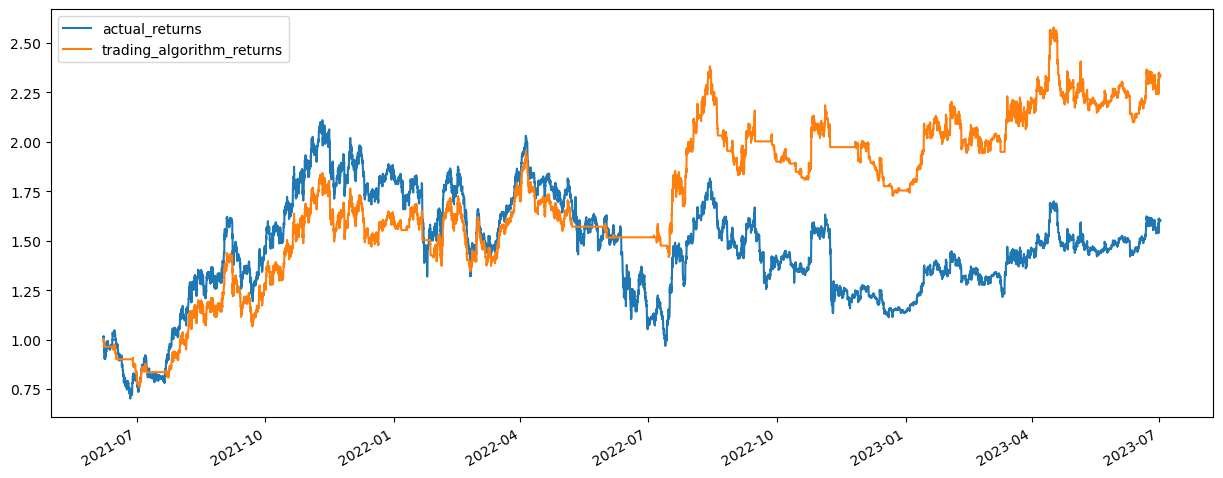

In [239]:
lr_predictions_df['futures_predicted'] = lr_predictions_df['trading_algorithm_returns'].replace(0,-1)
lr_predictions_df['Strategy_Returns'] = lr_predictions_df["actual_returns"] * lr_predictions_df["futures_predicted"]

# Plot the actual returns versus the strategy returns
(1 + lr_predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot(figsize=(15,6))

---
## 5 Model Building helpers

These utilities below are helpful for identifying the best models and understanding them better. However, they may take a long time to run. If needed, you can interrupt their execution as they are not essential for the machine learning process.

### Selecting best performing model 

In [240]:
model_selection(X_test_scaled,y_test)

Model Name  F1_Mean  F1_Standard Deviation
0  LinearDiscriminantAnalysis     0.72                  0.015
1        KNeighborsClassifier     0.93                  0.008
2      DecisionTreeClassifier     0.96                  0.006
3      RandomForestClassifier     0.97                  0.006
4        ExtraTreesClassifier     0.97                  0.004
5          AdaBoostClassifier     0.96                  0.005
6                         SVM     0.86                  0.013
7  GradientBoostingClassifier     0.96                  0.006
8                     XGBoost     0.97                  0.005

### SHAP Analysis 

In [241]:
# Resample X_test
upscaled_X_test = X_test.resample('1D').interpolate(method='linear')


In [242]:
# define which classifier to use 
clf = xgb_clf


# Initialize SHAP explainer
explainer = shap.Explainer(clf.predict, upscaled_X_test)

# Calculate SHAP values
shap_values = explainer(upscaled_X_test)

shap.summary_plot(shap_values, upscaled_X_test, plot_type="bar")

In the future `np.bool` will be defined as the corresponding NumPy scalar.


AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [ ]:
# SHAP Analysis 
# define which classifier to use 
clf = cb_clf

# Initialize SHAP explainer
explainer = shap.Explainer(clf.predict, upscaled_X_test)

# Calculate SHAP values
shap_values = explainer(upscaled_X_test)

shap.summary_plot(shap_values, upscaled_X_test, plot_type="bar")